In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pysta
import stc
import stcl

import os

%load_ext autoreload
%autoreload 2

## load clustering results

In [2]:
def load_clustering(dataset_name, tap=8, dim=3):
    folder_name = "{}_tap{}_cov_classic_cluster_dim{}".format(dataset_name, tap, dim)
#     filename = os.path.join(folder_name, "clusters_combined.csv")
    filename = os.path.join(folder_name, "clusters.csv")    

    return pd.read_csv(filename)

cluster_dim = 2
# cluster_dim = 3

cluster1 = load_clustering("20180618", dim=cluster_dim)
cluster1["dataset"] = "20180618"
cluster2 = load_clustering("20180621", dim=cluster_dim)
cluster2["dataset"] = "20180621"
cluster3 = load_clustering("20180626", dim=cluster_dim)
cluster3["dataset"] = "20180626"
# cluster4 = load_clustering("20180828")
# cluster4["dataset"] = "20180828"


# combine all patches 
# cluster = pd.concat([cluster1, cluster2, cluster3, cluster4])
cluster = pd.concat([cluster1, cluster2, cluster3])

print("total = ", len(cluster))
print(cluster["cell_type"].value_counts())
print(cluster["cell_type"].value_counts() / len(cluster))

cluster.info()

total =  389
OFF        169
unknown    129
ON          91
Name: cell_type, dtype: int64
OFF        0.434447
unknown    0.331620
ON         0.233933
Name: cell_type, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 155
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   channel_name   389 non-null    object 
 1   num_spikes     389 non-null    int64  
 2   cell_type      389 non-null    object 
 3   PSNR           389 non-null    float64
 4   eig1           389 non-null    float64
 5   eig2           389 non-null    float64
 6   eig3           389 non-null    float64
 7   converged      389 non-null    bool   
 8   PSNR1          389 non-null    float64
 9   PSNR2          388 non-null    float64
 10  weight1        389 non-null    float64
 11  weight2        389 non-null    float64
 12  inner_product  388 non-null    float64
 13  dataset        389 non-null    object 
dtypes: boo

## load classification results

In [3]:
classify_cnn = pd.read_csv("data/on_and_off_by_cnn_dim{}.csv".format(cluster_dim))
classify_cnn

dataset_name channel_name cell_type  inner_product  cell_type_true  \
0        20180618          12a       OFF       0.420599            -1.0   
1        20180618          12b        ON       0.255689             1.0   
2        20180618          12c   unknown      -0.280702             NaN   
3        20180618          13a       OFF       0.466382            -1.0   
4        20180618          13b        ON       0.185476             1.0   
..            ...          ...       ...            ...             ...   
384      20180626          86c        ON       0.117121             1.0   
385      20180626          86d        ON       0.476190             1.0   
386      20180626          87a       OFF       0.056832            -1.0   
387      20180626          87b        ON      -0.128974             1.0   
388      20180626          87c       OFF       0.222600            -1.0   

     cell_type_pred0  cell_type_pred1  cell_type_pred2  cell_type_prob0  \
0                 -1               -1               -1         0.007388   
1                  1                1                1         1.000000   
2                 -1               -1               -1         0.011115   
3                 -1               -1               -1         0.010306   
4                  1                1               -1         0.891065   
..               ...              ...              ...              ...   
384                1                1                1         0.972733   
385                1                1                1         0.980425   
386               -1               -1               -1         0.012749   
387                1                1                1         0.999258   
388               -1               -1               -1         0.014477   

     cell_type_prob1  cell_type_prob2 cell_type_on_and_off  
0           0.007968         0.008210              unknown  
1           0.999998         0.999965              unknown  
2           0.011437         0.044818              unknown  
3           0.010619         0.024960              unknown  
4           0.946656         0.230944               ON/OFF  
..               ...              ...                  ...  
384         0.978211         0.752078              unknown  
385         0.971767         0.512775              unknown  
386         0.015899         0.019359              unknown  
387         0.766921         0.997713              unknown  
388         0.048673         0.015188              unknown  

[389 rows x 12 columns]

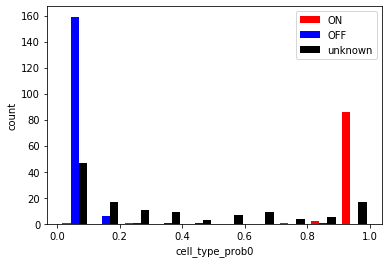

In [4]:
# cell_type_prob0 is a good indicator of STA cell type
pysta.plot_hist_by_cell_type(classify_cnn, "cell_type_prob0")

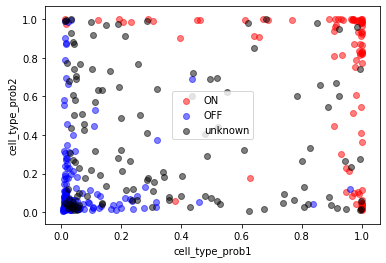

In [6]:
pysta.plot_scatter_by_group(classify_cnn, ["cell_type_prob1", "cell_type_prob2"])

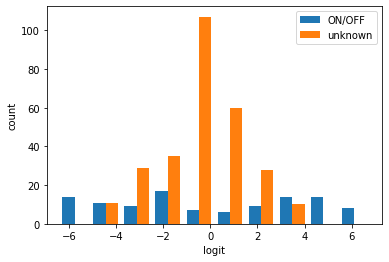

In [7]:
classify_cnn["logit"] = np.log2(classify_cnn["cell_type_prob1"]) - np.log2(classify_cnn["cell_type_prob2"])

pysta.plot_hist_by_group(classify_cnn, "logit", "cell_type_on_and_off")
# lager abs value of logit indicates ON/OFF cells

## merge classification results

In [8]:
# merge classification results
classify_cnn["dataset"] = classify_cnn["dataset_name"].astype(str)
# classify_cnn[["dataset","channel_name","cell_type_on_and_off"]].info()
cluster = cluster.merge(classify_cnn[["dataset","channel_name","cell_type_on_and_off", "cell_type_prob0", "cell_type_prob1", "cell_type_prob2", "logit"]], on=["dataset", "channel_name"])

Text(0, 0.5, 'cell_type_prob2')

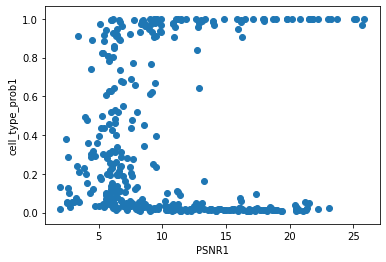

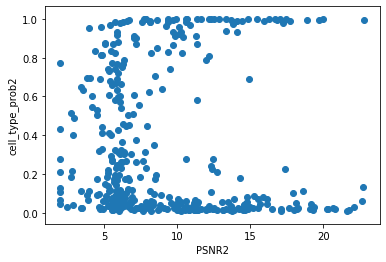

In [9]:
plt.figure()
plt.scatter(cluster["PSNR1"], cluster["cell_type_prob1"])
plt.xlabel("PSNR1")
plt.ylabel("cell_type_prob1")

plt.figure()
plt.scatter(cluster["PSNR2"], cluster["cell_type_prob2"])
plt.xlabel("PSNR2")
plt.ylabel("cell_type_prob2")

In [10]:
cluster.groupby("cell_type_on_and_off").mean()

num_spikes       PSNR      eig1      eig2      eig3  \
cell_type_on_and_off                                                         
ON/OFF                4633.321101  11.239790  1.401743  1.262941  1.205482   
unknown               3339.978571  14.253147  1.507087  1.374838  1.310521   

                      converged    PSNR1     PSNR2   weight1   weight2  \
cell_type_on_and_off                                                     
ON/OFF                     True  10.1881  8.146727  0.565103  0.434897   
unknown                    True  10.6254  9.353003  0.529861  0.470139   

                      inner_product  cell_type_prob0  cell_type_prob1  \
cell_type_on_and_off                                                    
ON/OFF                    -0.144878         0.564518         0.490553   
unknown                    0.073937         0.277268         0.288698   

                      cell_type_prob2    logit  
cell_type_on_and_off                            
ON/OFF                       0.486391 -0.10842  
unknown                      0.290519 -0.32960

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


cell_type_on_and_off
ON/OFF     [[AxesSubplot(0.125,0.758226;0.215278x0.121774...
unknown    [[AxesSubplot(0.125,0.758226;0.215278x0.121774...
dtype: object

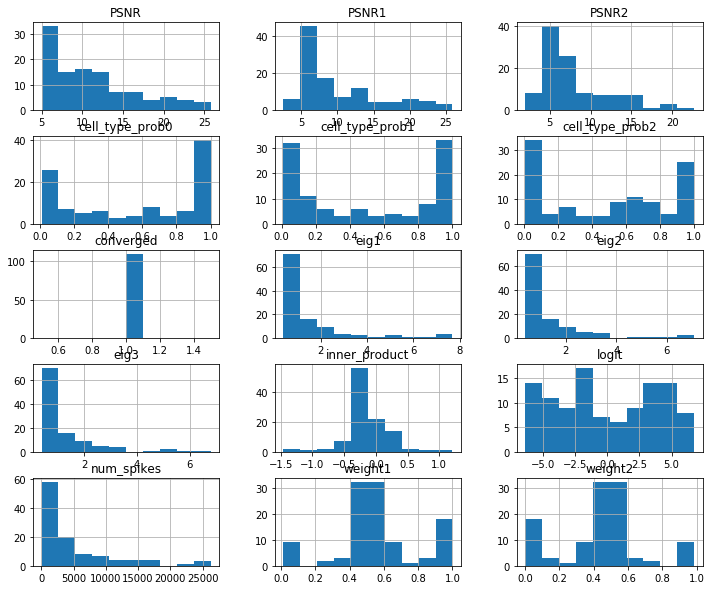

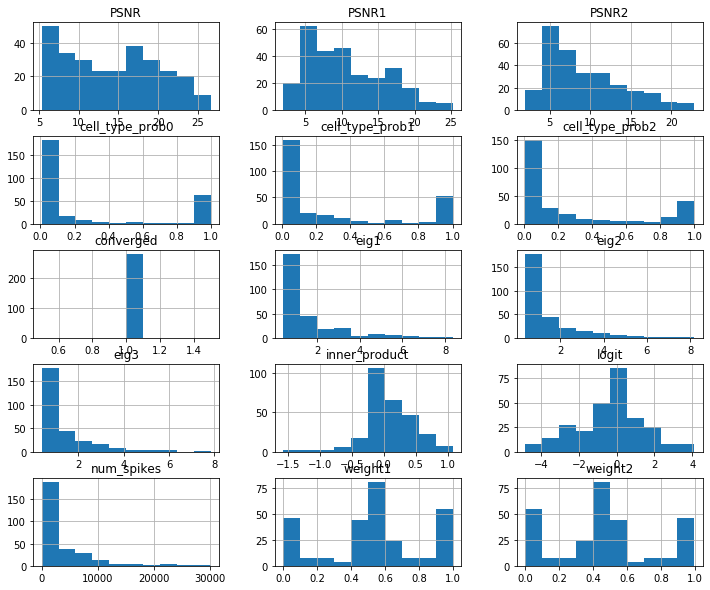

In [11]:
cluster.groupby("cell_type_on_and_off").hist(figsize=(12,10),layout=(5,3))

In [13]:
# def plot_scatter(cluster):
#     plt.figure(figsize=(12,10))
#     plt.subplot(221)
#     pysta.plot_scatter_by_cell_type(cluster, ["num_spikes", "PSNR"], ["ON", "OFF"], ["r","b"])

#     plt.subplot(222)
#     pysta.plot_scatter_by_cell_type(cluster, ["num_spikes", "PSNR"], ["ON", "OFF"], ["r","b"])
#     plt.xlim(0,2000)
    
#     plt.subplot(223)
#     pysta.plot_scatter_by_cell_type(cluster, ["num_spikes", "eig1"], ["ON", "OFF"], ["r","b"])
# #     plt.xscale('log')
# #     plt.yscale('log')

#     plt.subplot(224)
#     pysta.plot_scatter_by_cell_type(cluster, ["num_spikes", "eig1"], ["ON", "OFF"])
#     plt.xlim(0,2000)
    
    
# def plot_compare_scatter_(cluster):
#     plt.subplot(233)
#     pysta.plot_scatter_by_cell_type(cluster, ["num_spikes", "inner_product"], ["ON", "OFF"])
#     plt.xscale('log')
#     # plt.yscale('log')

#     plt.subplot(234)
#     pysta.plot_scatter_by_cell_type(cluster, ["PSNR", "PSNR1"], ["ON", "OFF"])
#     plt.plot([7.5,25], [7.5,25], 'k--')

#     plt.subplot(235)
#     pysta.plot_scatter_by_cell_type(cluster, ["PSNR", "PSNR2"], ["ON", "OFF"])
#     plt.plot([7.5,25], [7.5,25], 'k--')

# plot_scatter(cluster)

# plt.savefig("figure/combined_cluster_dim{}_PSNR_eig1.pdf".format(cluster_dim))
# plt.savefig("figure/combined_cluster_dim{}_PSNR_eig1".format( cluster_dim))



Text(0, 0.5, '| logit |')

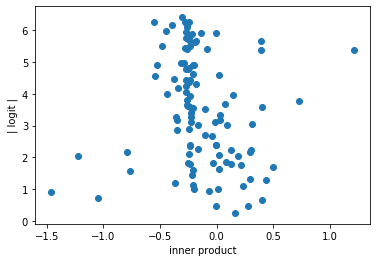

In [14]:
# plt.figure()
idx_on_and_off = cluster["cell_type_on_and_off"] == "ON/OFF"
plt.scatter(cluster.loc[idx_on_and_off,"inner_product"], np.abs(cluster.loc[idx_on_and_off,"logit"]))
plt.xlabel("inner product")
plt.ylabel("| logit |")
#pysta.plot_scatter_by_cell_type(cluster, ["inner_product", "logit"]) #, ["unknown"])
# plt.figure()
# pysta.plot_scatter_by_cell_type(cluster, ["num_spikes", "cell_type_prob2"]) # , ["unknown"])

In [15]:
np.log2(1)-np.log2(0.5)


1.0

## select channels with enough spikes

In [16]:
# with enough spikes
spike_per_dim = 2 # hyper parameter that I get to choose
# spike_per_dim = 4 # hyper parameter that I get to choose

idx_enough_spikes = cluster["num_spikes"]>512*spike_per_dim
cluster_with_enough_spikes = cluster.loc[idx_enough_spikes]

print("total = ", len(cluster_with_enough_spikes))
print(cluster_with_enough_spikes["cell_type"].value_counts())
print(cluster_with_enough_spikes["cell_type"].value_counts() / len(cluster_with_enough_spikes))


total =  218
OFF        107
ON          63
unknown     48
Name: cell_type, dtype: int64
OFF        0.490826
ON         0.288991
unknown    0.220183
Name: cell_type, dtype: float64


In [17]:
cluster_with_enough_spikes

channel_name  num_spikes cell_type       PSNR      eig1      eig2  \
0            12a        1978       OFF  12.186541  0.971392  0.754007   
1            12b        1228        ON   9.526389  0.920008  0.895442   
7            14a        5973        ON  25.775064  0.620785  0.571746   
8            14b        1212        ON  11.186482  0.795804  0.766490   
9            17a        5929   unknown   8.452868  0.436700  0.434049   
..           ...         ...       ...        ...       ...       ...   
378          83b        1300       OFF  14.727492  0.879242  0.851718   
382          86a        3186        ON  19.576154  0.952703  0.766365   
383          86b        1684   unknown   6.779709  0.788005  0.759195   
386          87a        9120       OFF  21.676952  0.590420  0.517161   
387          87b        3797        ON  16.662341  0.487358  0.482080   

         eig3  converged      PSNR1      PSNR2   weight1   weight2  \
0    0.737358       True  11.450823  10.235904  0.636834  0.363166   
1    0.871839       True   9.419680   7.839765  0.662558  0.337442   
7    0.562778       True  25.702134  15.884281  0.598530  0.401470   
8    0.746218       True  11.501885  10.593278  0.516448  0.483552   
9    0.430598       True   6.269053   5.988208  0.504045  0.495955   
..        ...        ...        ...        ...       ...       ...   
378  0.813824       True  14.368050  10.560972  0.570767  0.429233   
382  0.749286       True   9.892318  19.695189  0.276750  0.723250   
383  0.735989       True   6.928302   6.117002  0.336812  0.663188   
386  0.512286       True  19.043271  14.230278  0.600327  0.399673   
387  0.475510       True   9.090881  12.160747  0.469121  0.530879   

     inner_product   dataset cell_type_on_and_off  cell_type_prob0  \
0         0.420599  20180618              unknown         0.007388   
1         0.255689  20180618              unknown         1.000000   
7        -0.206751  20180618               ON/OFF         0.932818   
8        -0.076766  20180618              unknown         0.999931   
9        -0.251180  20180618               ON/OFF         0.051133   
..             ...       ...                  ...              ...   
378       0.310200  20180626              unknown         0.014045   
382       0.588351  20180626              unknown         0.996241   
383      -0.003025  20180626               ON/OFF         0.946782   
386       0.056832  20180626              unknown         0.012749   
387      -0.128974  20180626              unknown         0.999258   

     cell_type_prob1  cell_type_prob2     logit  
0           0.007968         0.008210 -0.043210  
1           0.999998         0.999965  0.000047  
7           0.967521         0.082154  3.557893  
8           0.998910         0.982262  0.024247  
9           0.529524         0.043180  3.616265  
..               ...              ...       ...  
378         0.016215         0.014596  0.151714  
382         0.967424         0.995182 -0.040813  
383         0.187967         0.977177 -2.378143  
386         0.015899         0.019359 -0.284050  
387         0.766921         0.997713 -0.379547  

[218 rows x 19 columns]

In [18]:
cluster_with_enough_spikes.groupby("cell_type_on_and_off")["cell_type"].value_counts()

cell_type_on_and_off  cell_type
ON/OFF                unknown      29
                      ON           25
                      OFF          10
unknown               OFF          97
                      ON           38
                      unknown      19
Name: cell_type, dtype: int64

In [19]:
cluster_with_enough_spikes.groupby("cell_type_on_and_off").mean()

num_spikes       PSNR      eig1      eig2      eig3  \
cell_type_on_and_off                                                         
ON/OFF                7665.515625  13.237441  0.577349  0.540370  0.530572   
unknown               5769.584416  17.683198  0.656364  0.616371  0.605777   

                      converged      PSNR1      PSNR2   weight1   weight2  \
cell_type_on_and_off                                                        
ON/OFF                     True  12.296490   9.651816  0.523037  0.476963   
unknown                    True  12.871459  11.340464  0.513189  0.486811   

                      inner_product  cell_type_prob0  cell_type_prob1  \
cell_type_on_and_off                                                    
ON/OFF                    -0.236210         0.567102         0.499880   
unknown                    0.004336         0.288724         0.298676   

                      cell_type_prob2     logit  
cell_type_on_and_off                             
ON/OFF                       0.476746 -0.108469  
unknown                      0.303607 -0.394496

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


cell_type_on_and_off
ON/OFF     [[AxesSubplot(0.125,0.758226;0.215278x0.121774...
unknown    [[AxesSubplot(0.125,0.758226;0.215278x0.121774...
dtype: object

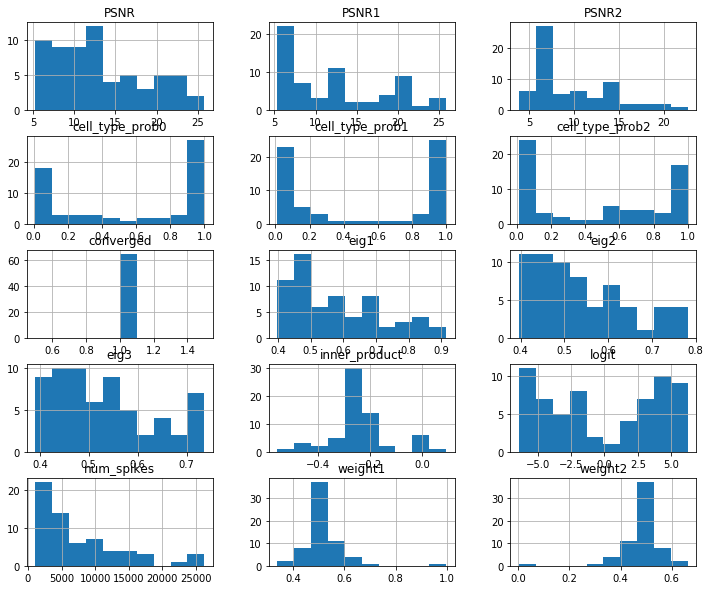

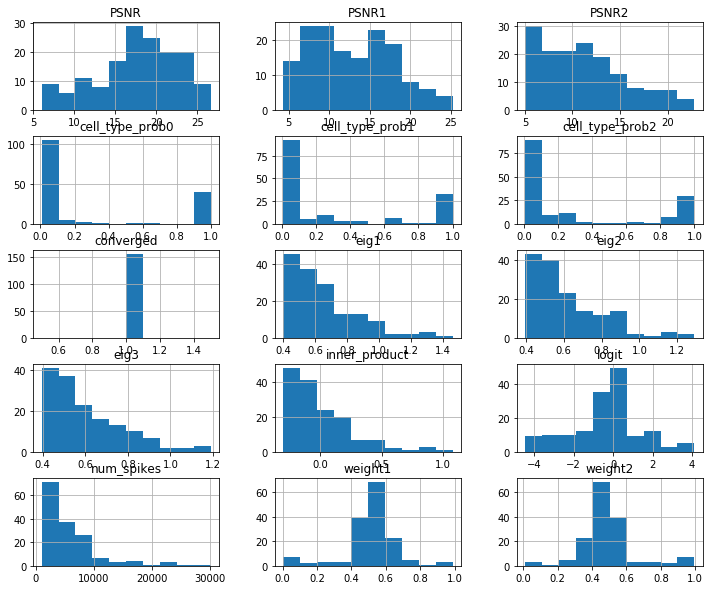

In [20]:
cluster_with_enough_spikes.groupby("cell_type_on_and_off").hist(figsize=(12,10),layout=(5,3))

## sort by  |logit|

In [21]:
cluster_with_enough_spikes["abs_logit"] = np.abs(cluster_with_enough_spikes["logit"])
       
    
idx_diff = cluster_with_enough_spikes["cell_type_on_and_off"] == "ON/OFF"    
cluster_on_and_off = cluster_with_enough_spikes.loc[idx_diff].sort_values('abs_logit', ascending=False)

cluster_on_and_off.to_csv("cluster_dim{}_on_and_off_by_cnn.csv".format(cluster_dim), index=None)
print(len(cluster_on_and_off))
cluster_on_and_off.head(30)#.sort_values("dataset")
# cluster_with_enough_samples.sort_values(['dataset','inner_product'])

64


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


channel_name  num_spikes cell_type       PSNR      eig1      eig2  \
300          37b        9568       OFF  18.715314  0.542621  0.476537   
175          42b        8472        ON  21.819161  0.567641  0.502737   
139          25a       26155   unknown  10.224226  0.422080  0.414922   
297          36c        4098   unknown  10.318830  0.798256  0.620102   
227          85b        4002        ON  11.494061  0.678136  0.597015   
355          71b        7557        ON  23.712959  0.575136  0.510658   
38           32b        3530        ON  16.838700  0.862429  0.749463   
342          62b        2308       OFF  12.982289  0.559727  0.550488   
356          71c        2912        ON  13.760327  0.630695  0.600578   
21           23a       12115       OFF  22.562123  0.604328  0.517577   
171          41a       16997       OFF  19.648014  0.450724  0.432585   
135          23a       13447   unknown  12.650385  0.456403  0.445747   
45           36a        5207   unknown   5.783477  0.468460  0.461560   
153          33a       14055   unknown  10.983452  0.429599  0.423111   
156          34a       12044       OFF  21.555734  0.457721  0.447231   
176          43a       10481       OFF  15.449190  0.491420  0.465993   
132          22b       15606       OFF  16.500673  0.443572  0.439005   
257          22a        2860        ON  17.556724  0.838246  0.704459   
64           46a        3505   unknown   6.157515  0.495557  0.494839   
188          47b        1590        ON  21.610161  0.678190  0.638039   
319          46b        2762       OFF  10.083432  0.592556  0.580456   
258          22b        2413   unknown   6.267735  0.835159  0.782430   
362          73a        3329        ON  23.010551  0.890397  0.728066   
195          61a        6741   unknown   7.826017  0.497795  0.488286   
142          26a        9169   unknown  11.489201  0.455029  0.449609   
144          26c        6699        ON  20.090976  0.498963  0.470083   
55           42b        3937        ON  21.174844  0.768183  0.649924   
43           34b        4208        ON  18.520772  0.706069  0.597161   
136          23b        4379   unknown   8.533363  0.514523  0.505090   
151          32a       11842        ON  23.692912  0.544881  0.489408   

         eig3  converged      PSNR1      PSNR2   weight1   weight2  \
300  0.469468       True  20.694819  15.913280  0.518498  0.481502   
175  0.496190       True  22.212132  13.903167  0.540581  0.459419   
139  0.406125       True   7.759385  10.137703  0.505274  0.494726   
297  0.613533       True  18.892517  18.855896  0.524121  0.475879   
227  0.581718       True  15.846811  14.866739  0.515823  0.484177   
355  0.508055       True  25.080139  19.315994  0.541918  0.458082   
38   0.716215       True  17.936124  14.497231  0.647646  0.352354   
342  0.547940       True   8.101284   7.069528  0.503116  0.496884   
356  0.589766       True  13.720303  13.828661  0.432951  0.567049   
21   0.516272       True  20.522708  11.367329  0.602274  0.397726   
171  0.428108       True  21.252288  11.938636  0.533711  0.466289   
135  0.437169       True  11.757749   6.666435  0.491849  0.508151   
45   0.458992       True   6.601859   5.846144  0.495079  0.504921   
153  0.422443       True   6.441576  11.627309  0.498022  0.501978   
156  0.442456       True  15.542044   7.415672  0.517425  0.482575   
176  0.461663       True  12.199408   5.589868  0.537456  0.462544   
132  0.435544       True  12.984921  13.880398  0.510985  0.489015   
257  0.671715       True  18.716530  14.826105  0.647365  0.352635   
64   0.488377       True   5.433181   5.653084  0.509251  0.490749   
188  0.635664       True  20.185931   5.962553  0.700626  0.299374   
319  0.562291       True  12.540200   8.637063  0.502355  0.497645   
258  0.732217       True  12.865903  10.592013  0.380812  0.619188   
362  0.726651       True  21.512453   7.492515  0.590434  0.409566   
195  0.475730       True  12.518911  14.101404  0.467577  0.

In [22]:
# load results
# cluster_on_and_off.to_csv("cluster_on_and_off_dim{}.csv".format(cluster_dim))

Text(0, 0.5, 'prob2')

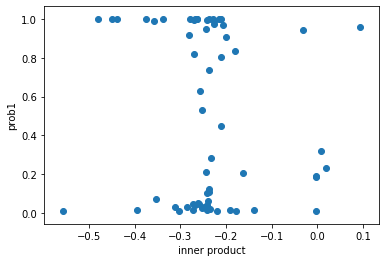

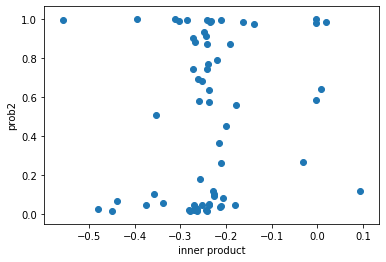

In [23]:
plt.figure()
plt.scatter(cluster_on_and_off["inner_product"], cluster_on_and_off["cell_type_prob1"])
plt.xlabel("inner product")
plt.ylabel("prob1")
# plt.ylabel("logit")

plt.figure()
plt.scatter(cluster_on_and_off["inner_product"], cluster_on_and_off["cell_type_prob2"])
plt.xlabel("inner product")
plt.ylabel("prob2")

# np.corrcoef(cluster_on_and_off["inner_product"], np.abs(cluster_on_and_off["logit"]))[0,1]

-0.413080471058296

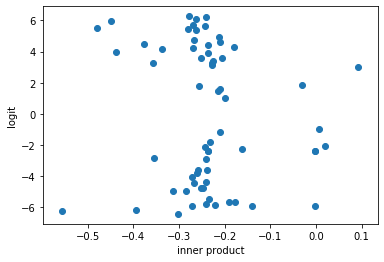

In [24]:
plt.scatter(cluster_on_and_off["inner_product"], cluster_on_and_off["logit"])
# plt.scatter(cluster_on_and_off["inner_product"], np.abs(cluster_on_and_off["logit"]))
plt.xlabel("inner product")
plt.ylabel("logit")
# plt.ylabel("|logit|")

np.corrcoef(cluster_on_and_off["inner_product"], np.abs(cluster_on_and_off["logit"]))[0,1]

In [25]:
np.log2(1) - np.log2(0.01)

6.643856189774724

## plot

/Users/yyoo/src/pysta2/stcl.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 8))
/Users/yyoo/src/pysta2/stcl.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 4))
/Users/yyoo/src/pysta2/stcl.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 

/Users/yyoo/src/pysta2/stcl.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 8))
/Users/yyoo/src/pysta2/stcl.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 4))
/Users/yyoo/src/pysta2/stcl.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 

/Users/yyoo/src/pysta2/stcl.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 8))
/Users/yyoo/src/pysta2/stcl.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 4))
/Users/yyoo/src/pysta2/stcl.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 

/Users/yyoo/src/pysta2/stcl.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 8))
/Users/yyoo/src/pysta2/stcl.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 4))
/Users/yyoo/src/pysta2/stcl.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 

/Users/yyoo/src/pysta2/stcl.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 8))
/Users/yyoo/src/pysta2/stcl.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 4))
/Users/yyoo/src/pysta2/stcl.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 

<Figure size 1440x576 with 0 Axes>

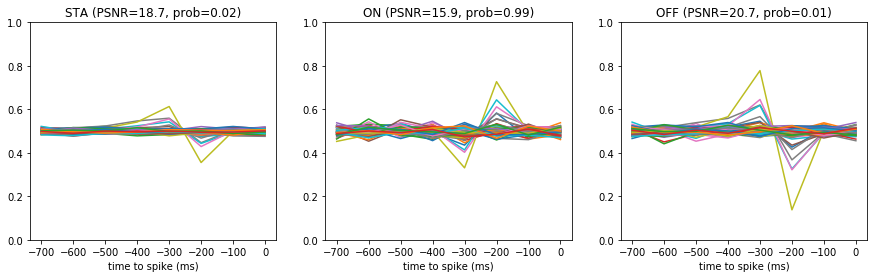

<Figure size 1440x576 with 0 Axes>

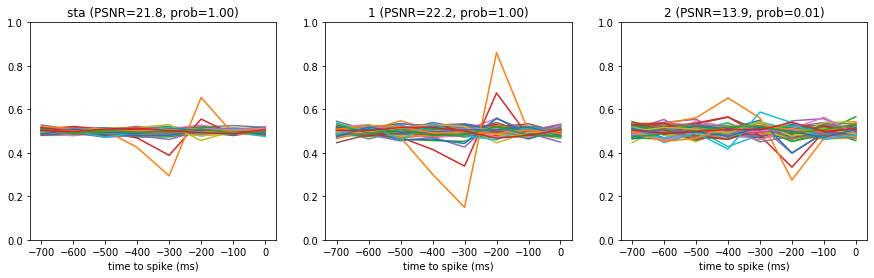

<Figure size 1440x576 with 0 Axes>

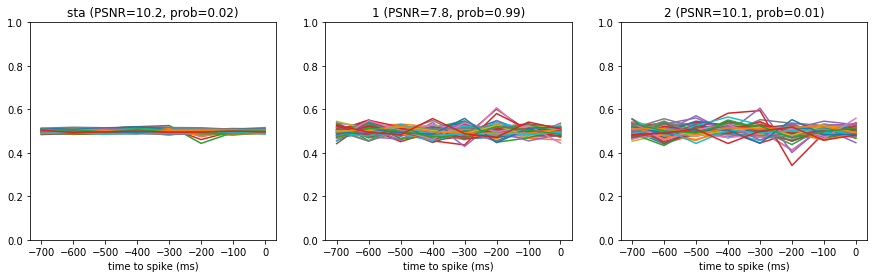

<Figure size 1440x576 with 0 Axes>

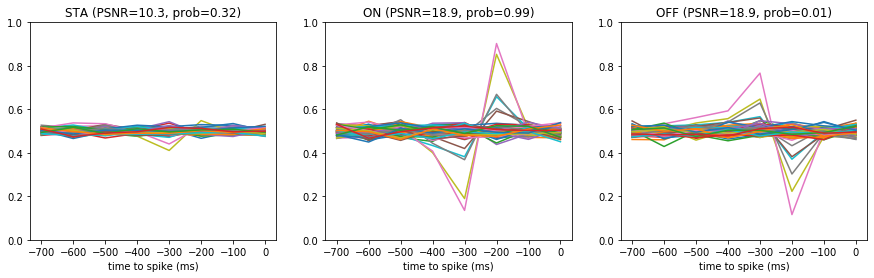

<Figure size 1440x576 with 0 Axes>

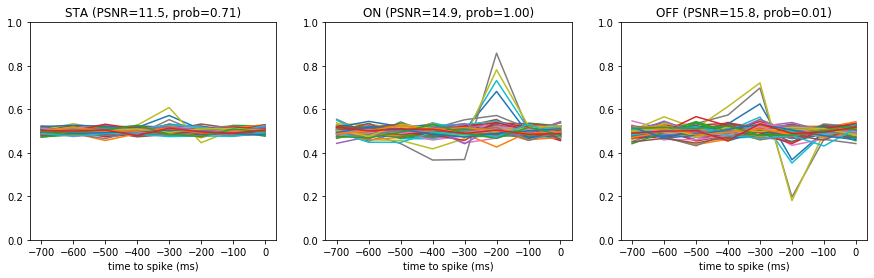

<Figure size 1440x576 with 0 Axes>

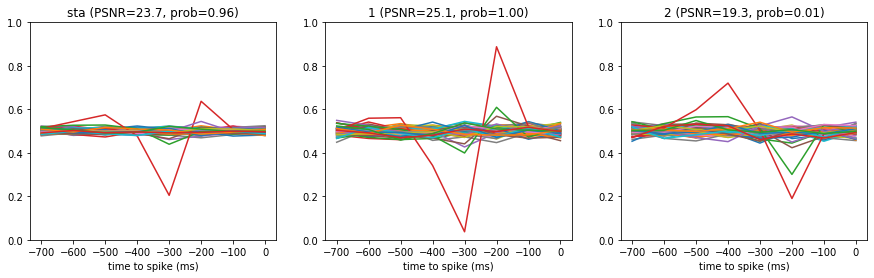

<Figure size 1440x576 with 0 Axes>

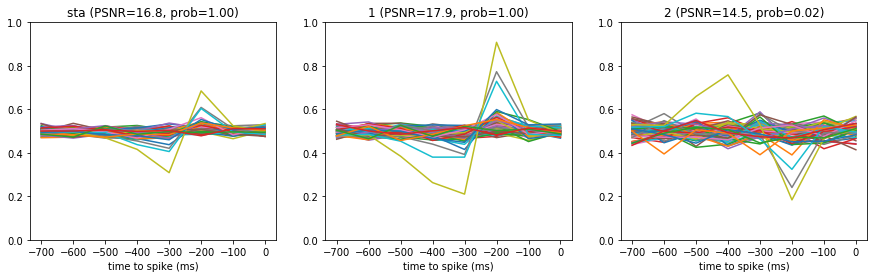

<Figure size 1440x576 with 0 Axes>

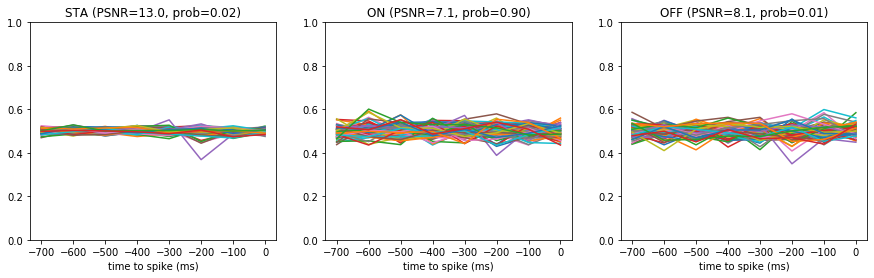

<Figure size 1440x576 with 0 Axes>

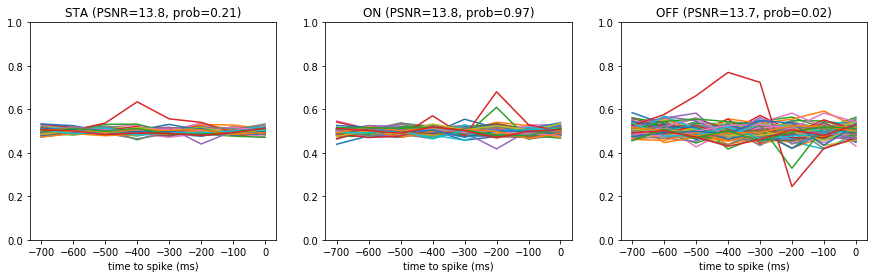

<Figure size 1440x576 with 0 Axes>

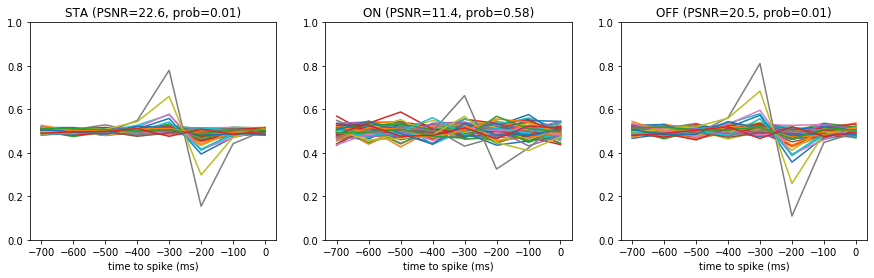

<Figure size 1440x576 with 0 Axes>

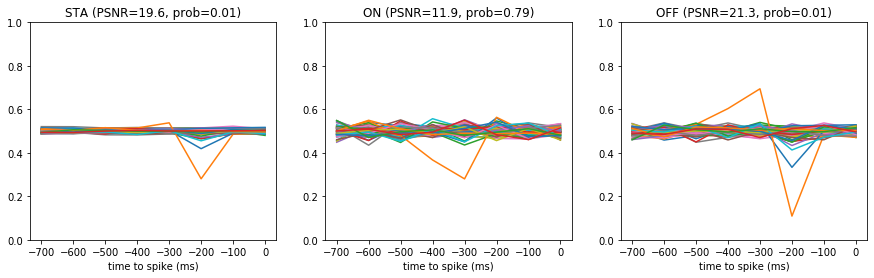

<Figure size 1440x576 with 0 Axes>

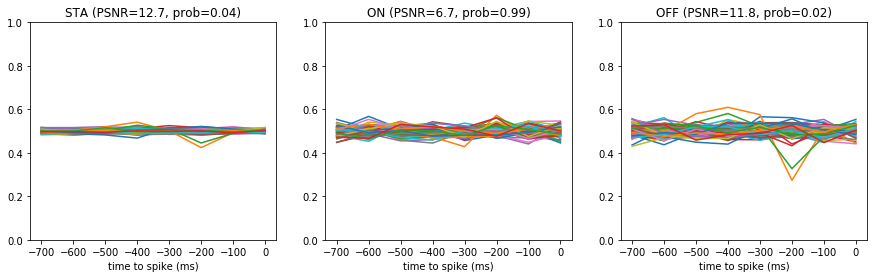

<Figure size 1440x576 with 0 Axes>

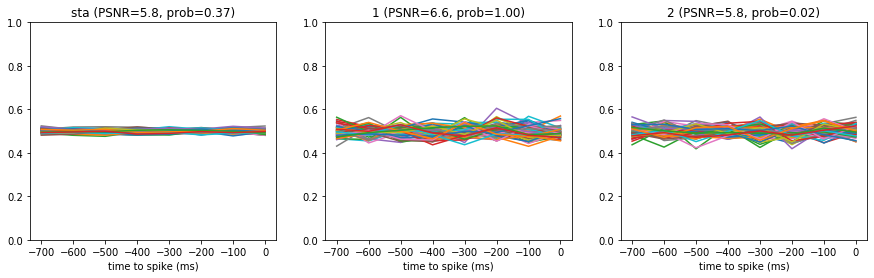

<Figure size 1440x576 with 0 Axes>

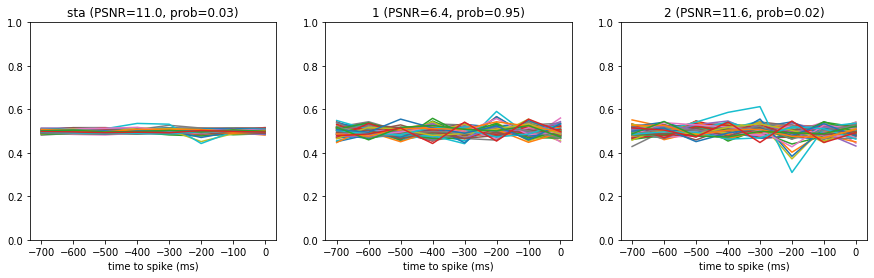

<Figure size 1440x576 with 0 Axes>

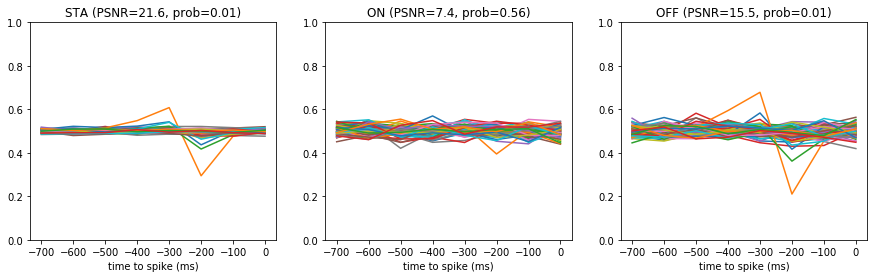

<Figure size 1440x576 with 0 Axes>

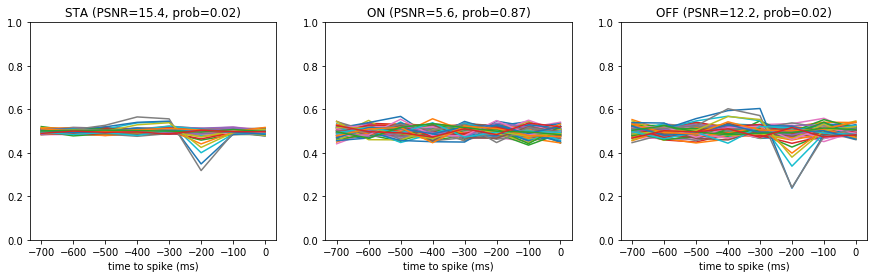

<Figure size 1440x576 with 0 Axes>

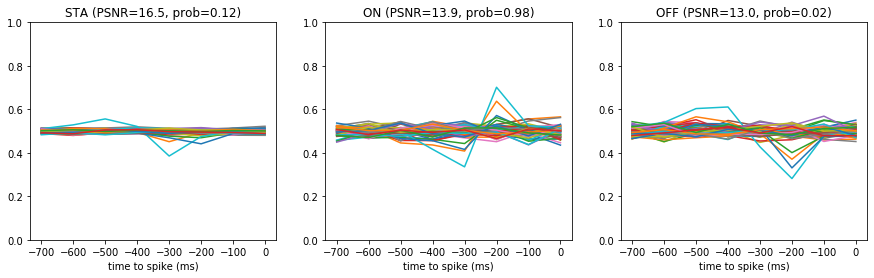

<Figure size 1440x576 with 0 Axes>

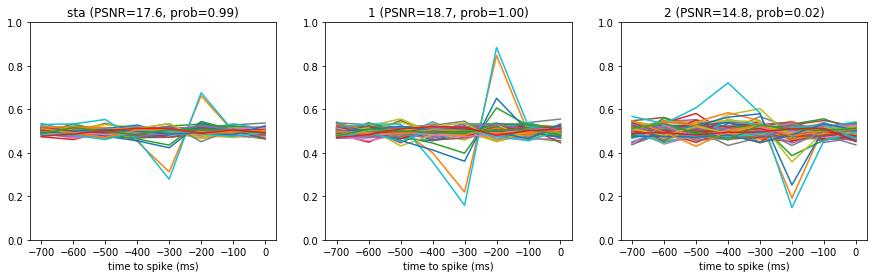

<Figure size 1440x576 with 0 Axes>

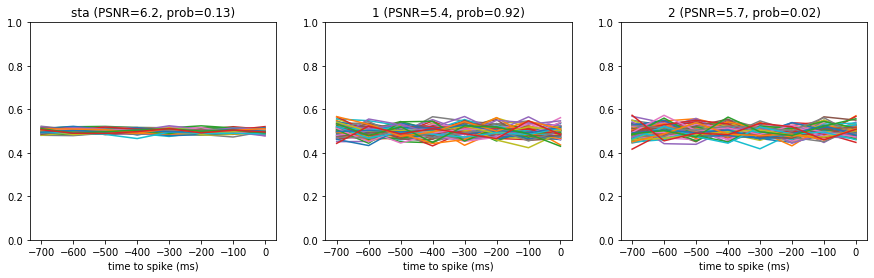

<Figure size 1440x576 with 0 Axes>

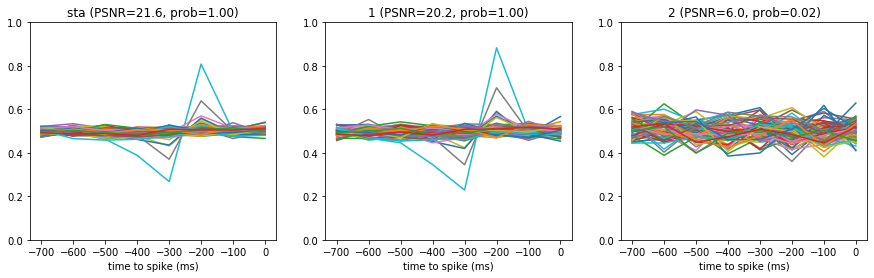

<Figure size 1440x576 with 0 Axes>

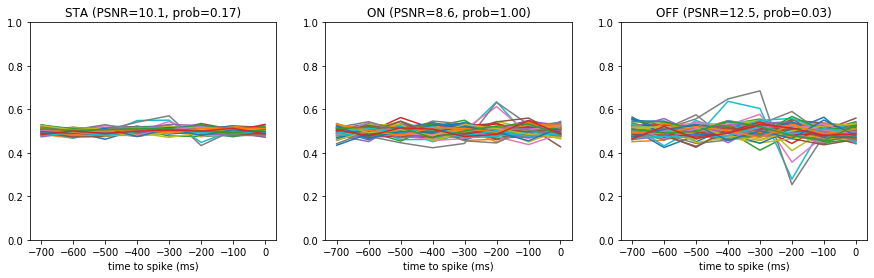

<Figure size 1440x576 with 0 Axes>

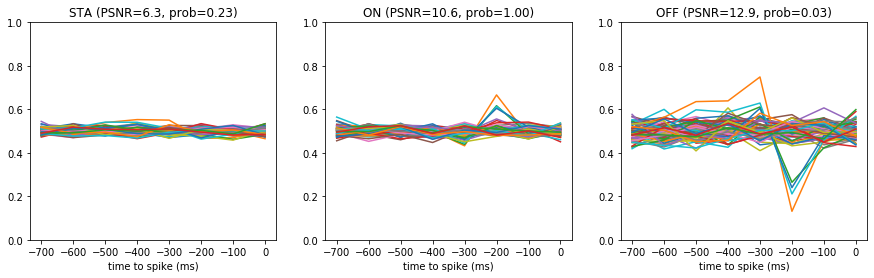

<Figure size 1440x576 with 0 Axes>

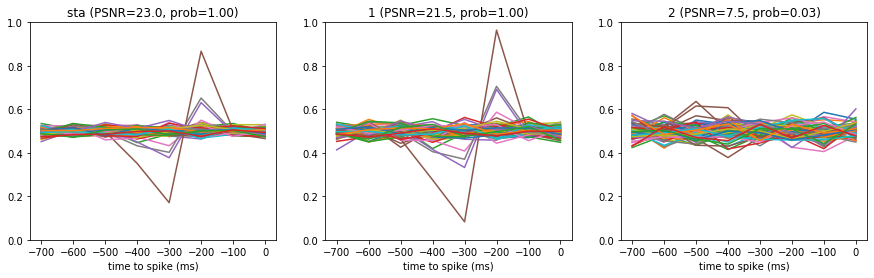

<Figure size 1440x576 with 0 Axes>

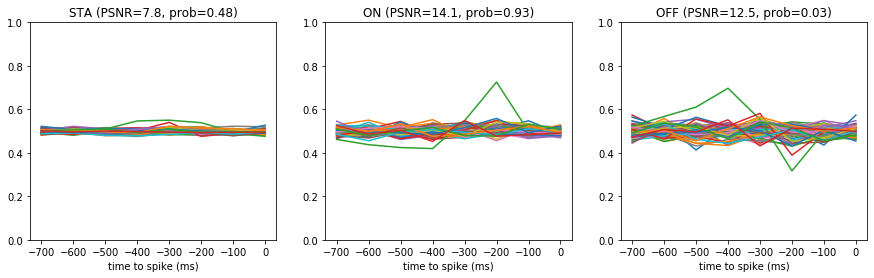

<Figure size 1440x576 with 0 Axes>

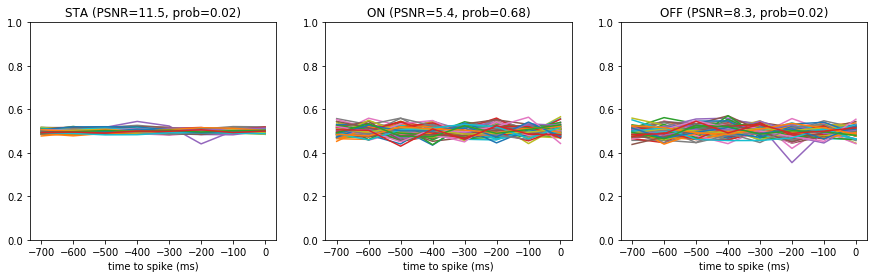

<Figure size 1440x576 with 0 Axes>

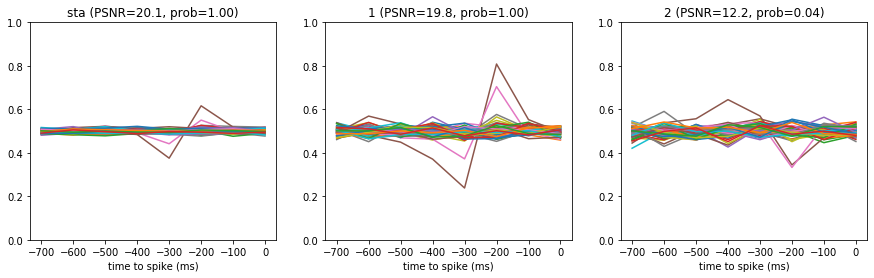

<Figure size 1440x576 with 0 Axes>

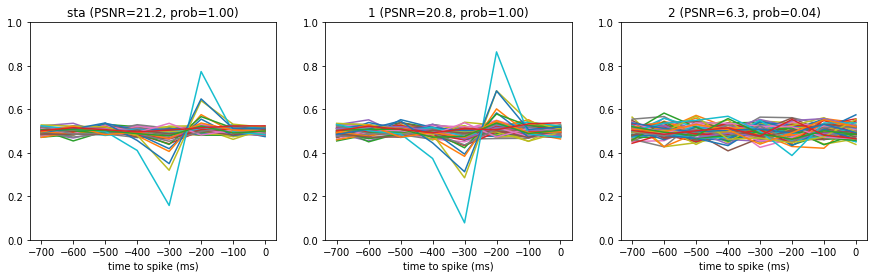

<Figure size 1440x576 with 0 Axes>

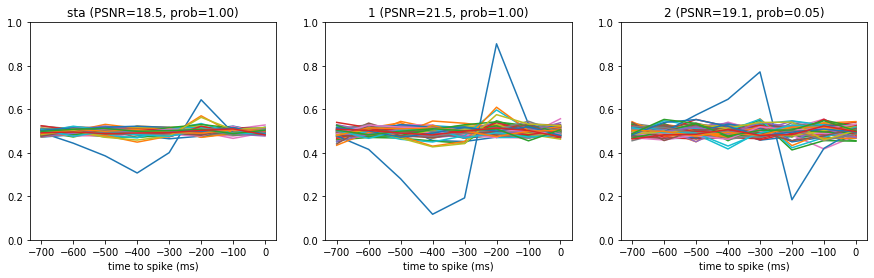

<Figure size 1440x576 with 0 Axes>

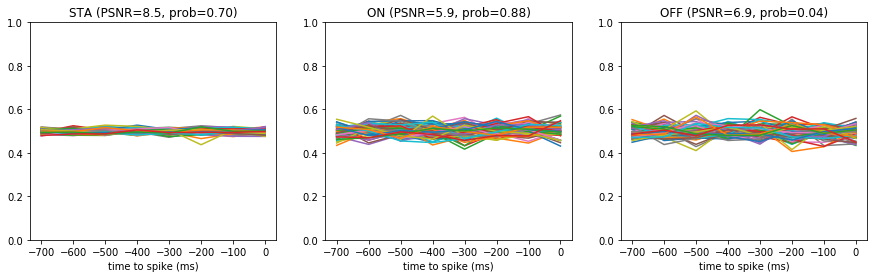

<Figure size 1440x576 with 0 Axes>

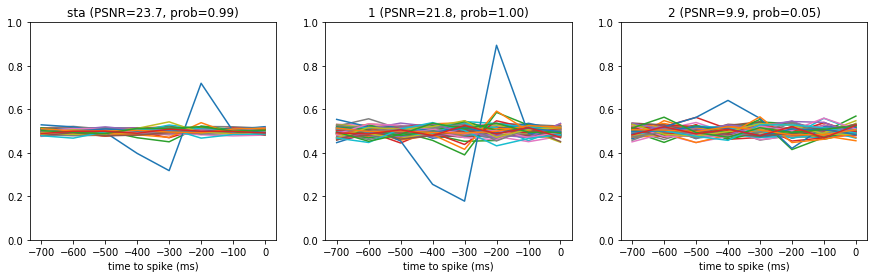

<Figure size 1440x576 with 0 Axes>

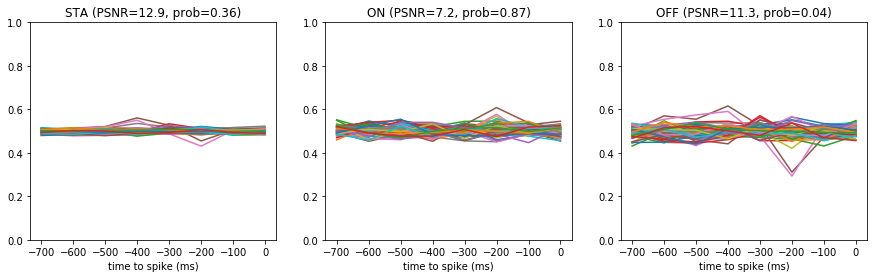

<Figure size 1440x576 with 0 Axes>

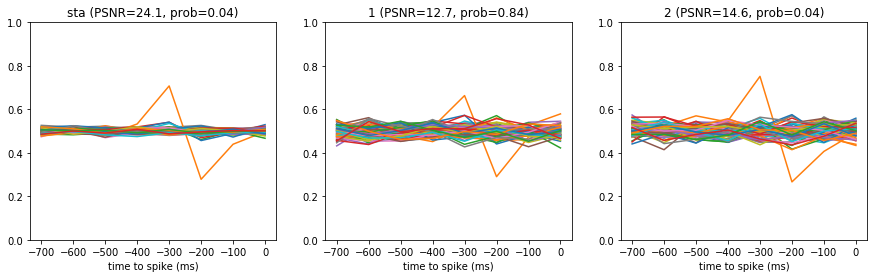

<Figure size 1440x576 with 0 Axes>

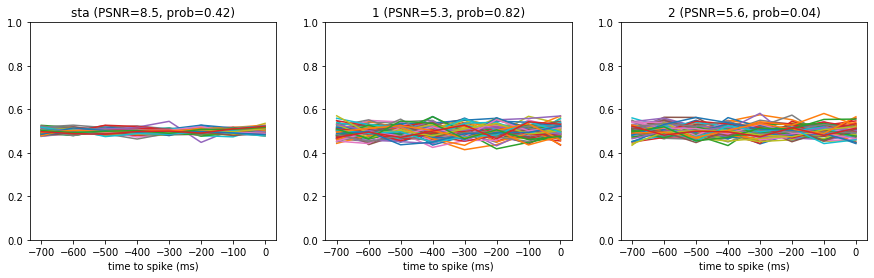

<Figure size 1440x576 with 0 Axes>

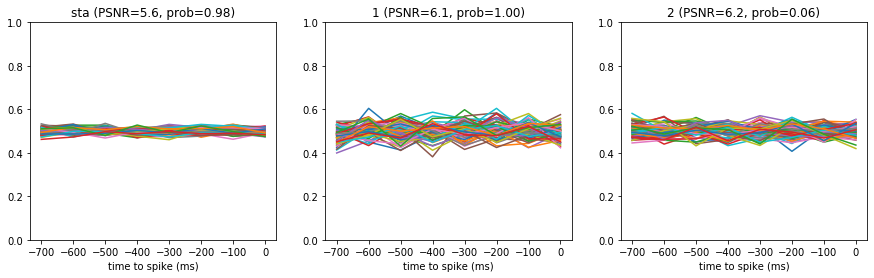

<Figure size 1440x576 with 0 Axes>

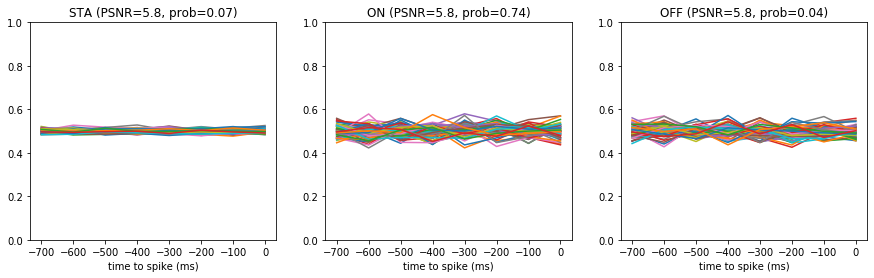

<Figure size 1440x576 with 0 Axes>

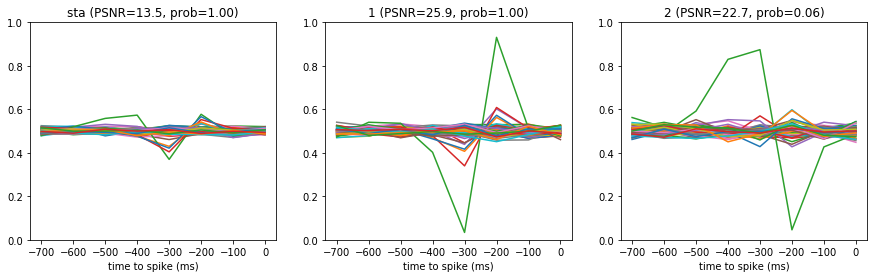

<Figure size 1440x576 with 0 Axes>

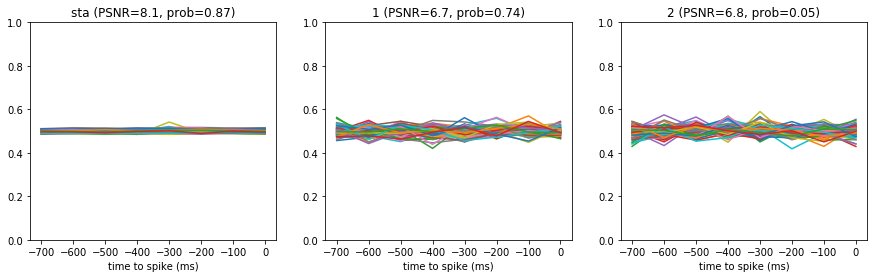

<Figure size 1440x576 with 0 Axes>

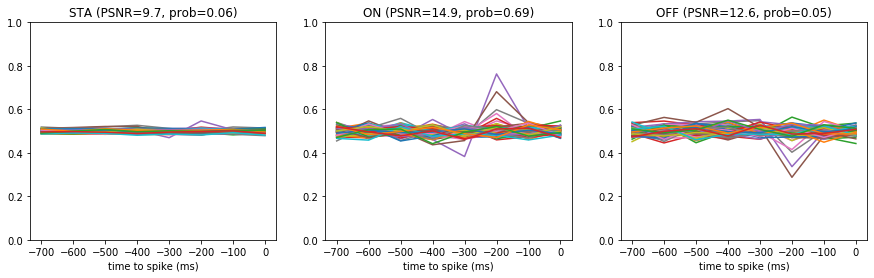

<Figure size 1440x576 with 0 Axes>

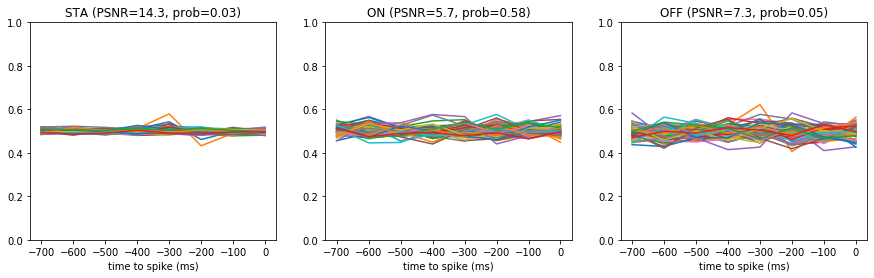

<Figure size 1440x576 with 0 Axes>

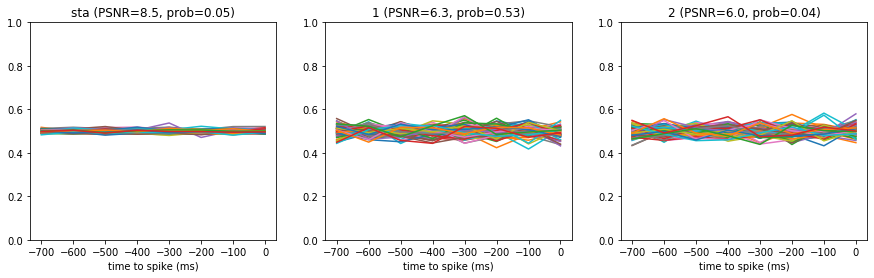

<Figure size 1440x576 with 0 Axes>

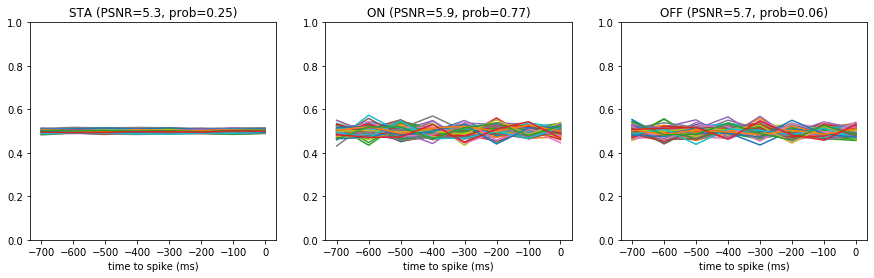

<Figure size 1440x576 with 0 Axes>

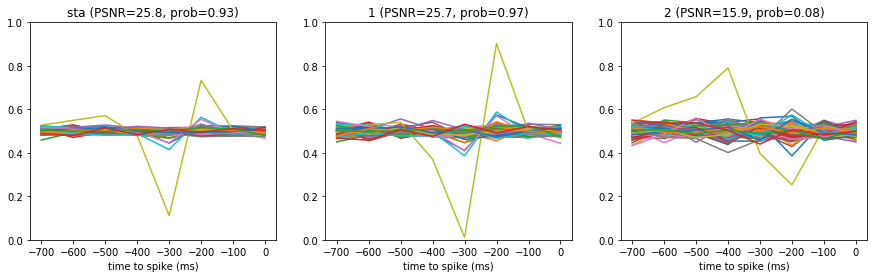

<Figure size 1440x576 with 0 Axes>

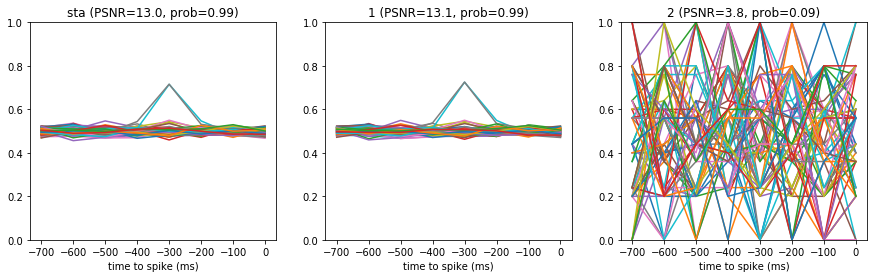

<Figure size 1440x576 with 0 Axes>

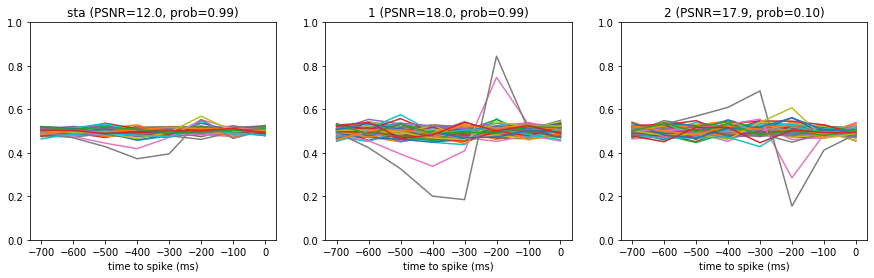

<Figure size 1440x576 with 0 Axes>

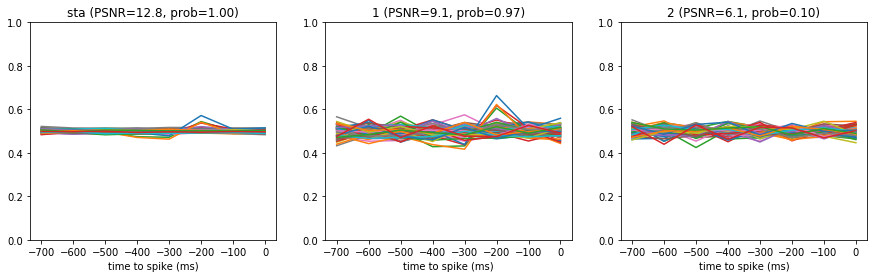

<Figure size 1440x576 with 0 Axes>

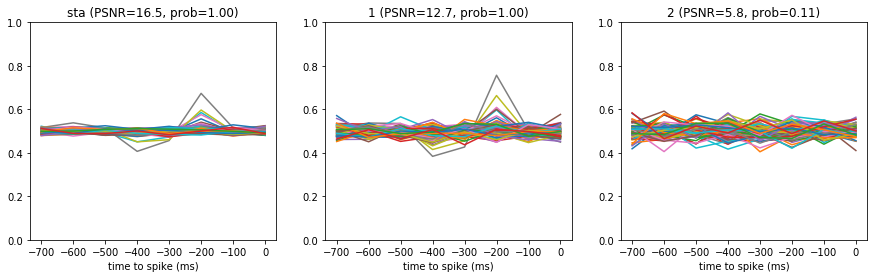

<Figure size 1440x576 with 0 Axes>

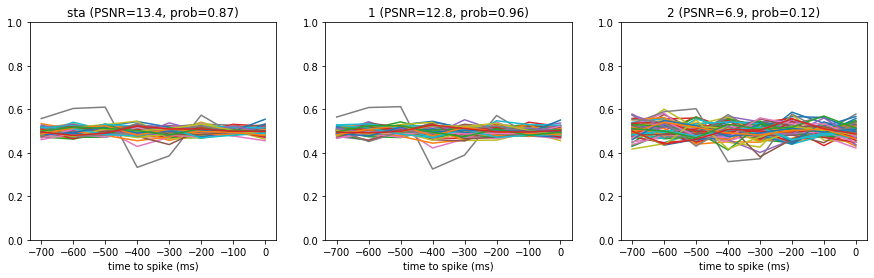

<Figure size 1440x576 with 0 Axes>

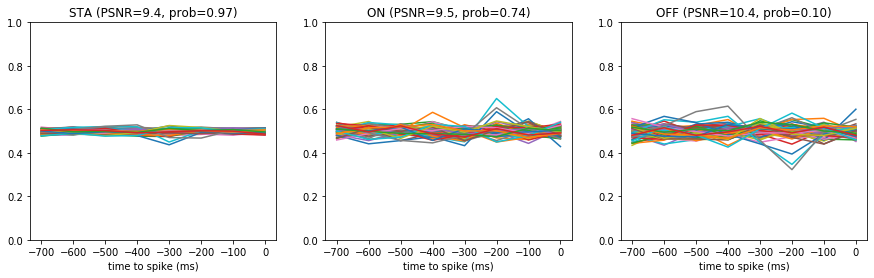

<Figure size 1440x576 with 0 Axes>

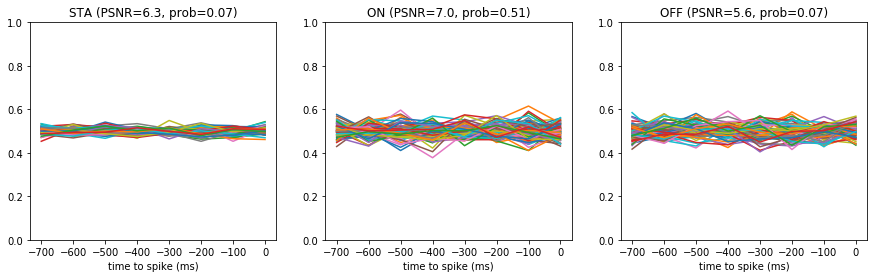

<Figure size 1440x576 with 0 Axes>

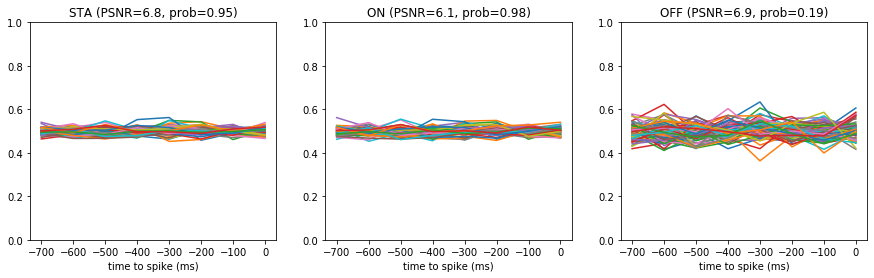

<Figure size 1440x576 with 0 Axes>

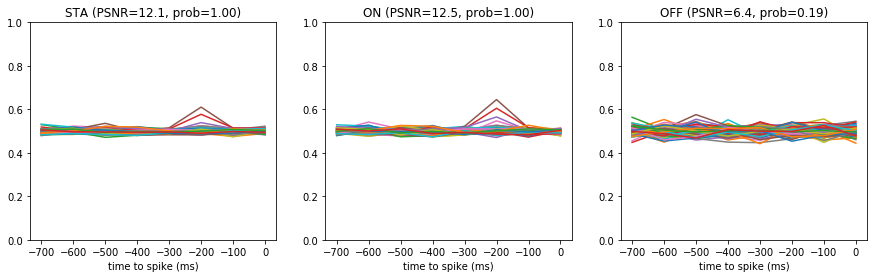

<Figure size 1440x576 with 0 Axes>

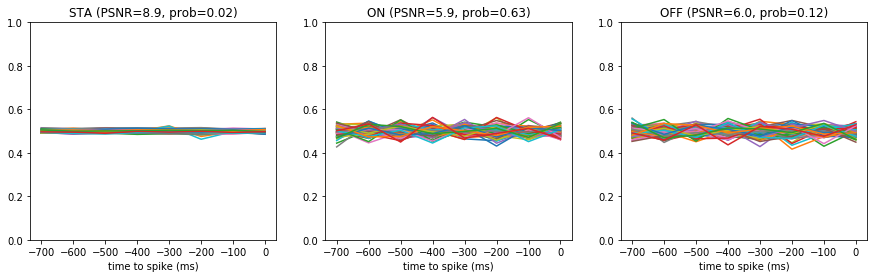

<Figure size 1440x576 with 0 Axes>

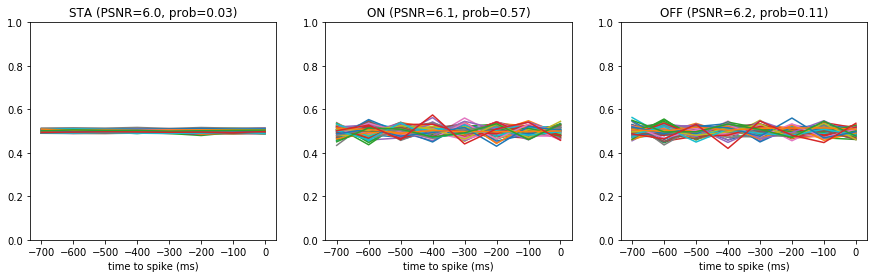

<Figure size 1440x576 with 0 Axes>

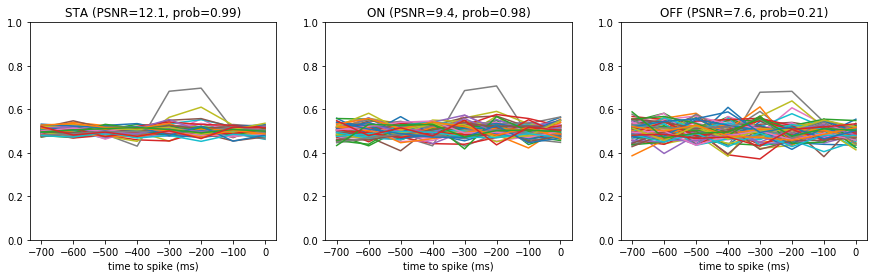

<Figure size 1440x576 with 0 Axes>

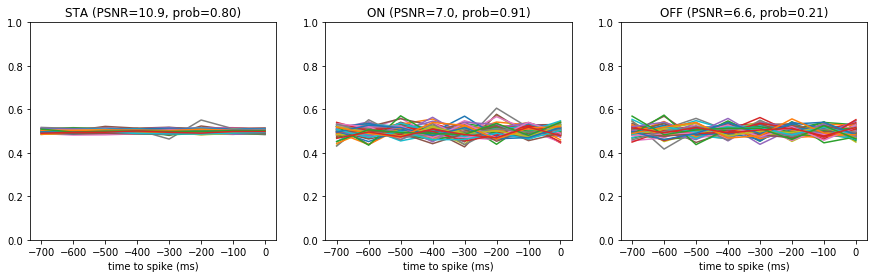

<Figure size 1440x576 with 0 Axes>

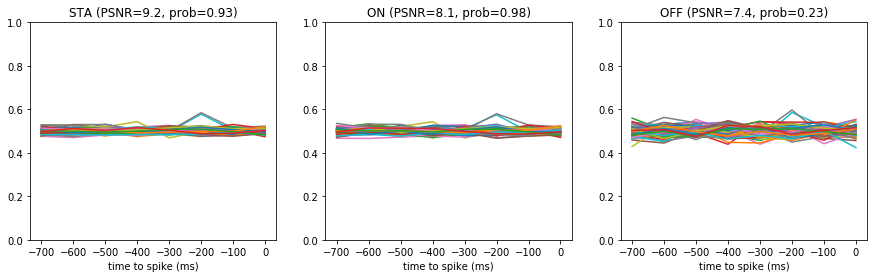

<Figure size 1440x576 with 0 Axes>

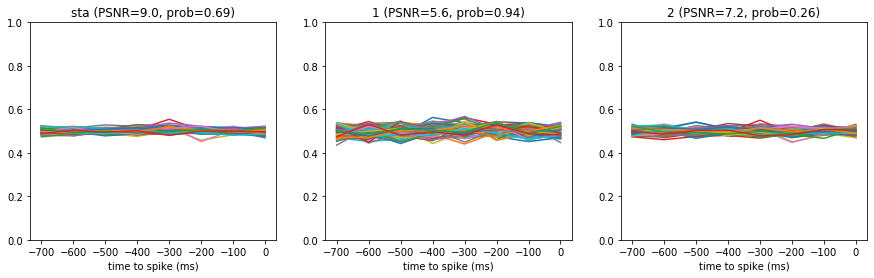

<Figure size 1440x576 with 0 Axes>

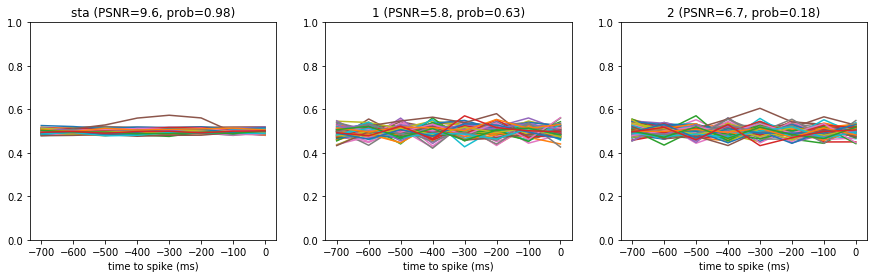

<Figure size 1440x576 with 0 Axes>

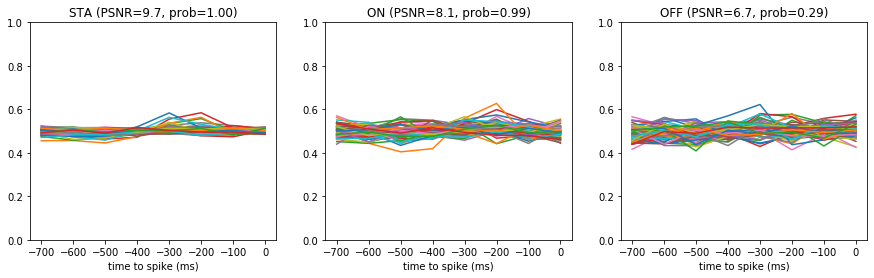

<Figure size 1440x576 with 0 Axes>

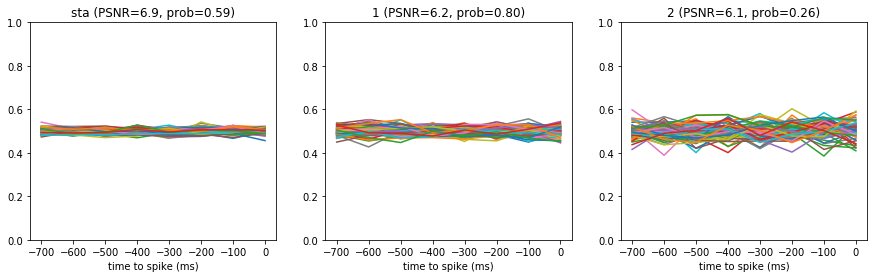

<Figure size 1440x576 with 0 Axes>

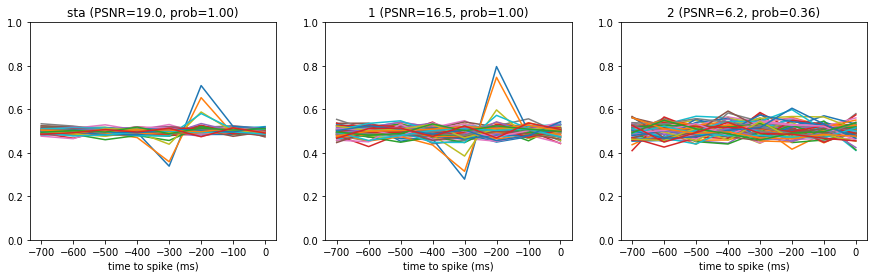

<Figure size 1440x576 with 0 Axes>

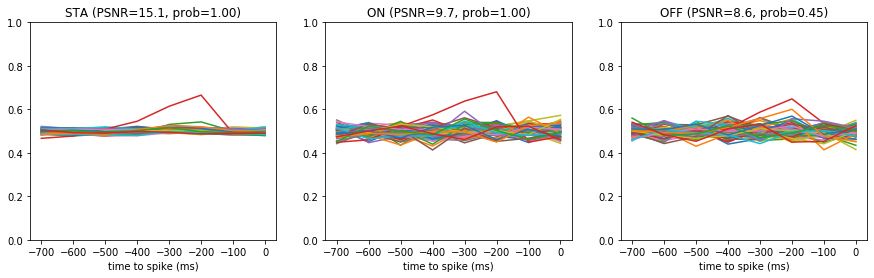

<Figure size 1440x576 with 0 Axes>

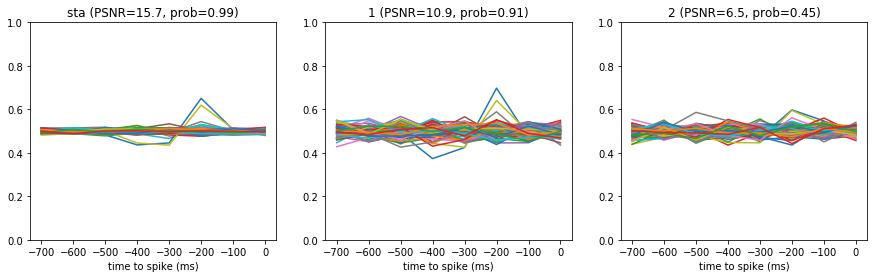

<Figure size 1440x576 with 0 Axes>

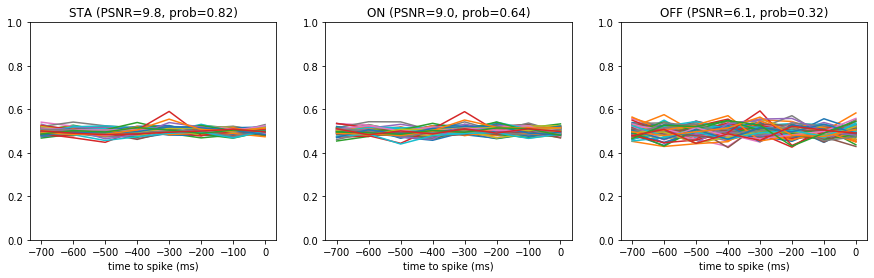

<Figure size 1440x576 with 0 Axes>

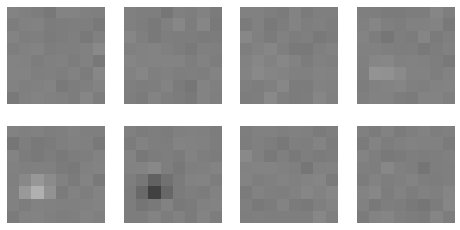

<Figure size 1440x576 with 0 Axes>

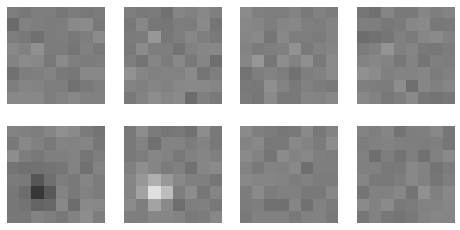

<Figure size 1440x576 with 0 Axes>

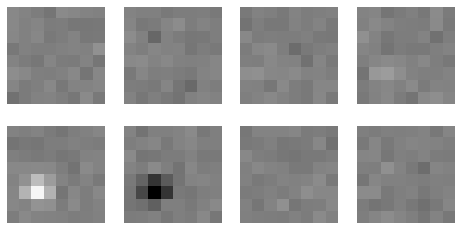

<Figure size 1440x576 with 0 Axes>

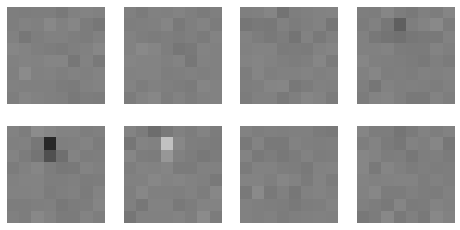

<Figure size 1440x576 with 0 Axes>

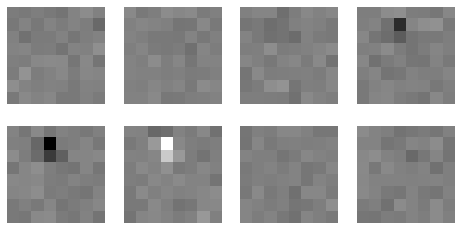

<Figure size 1440x576 with 0 Axes>

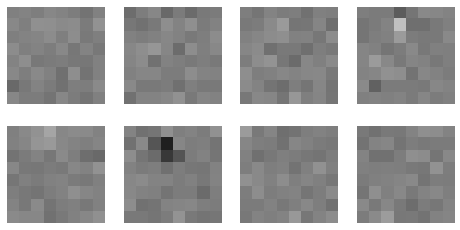

<Figure size 1440x576 with 0 Axes>

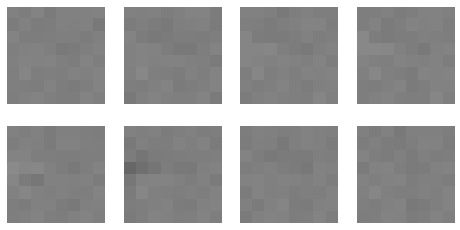

<Figure size 1440x576 with 0 Axes>

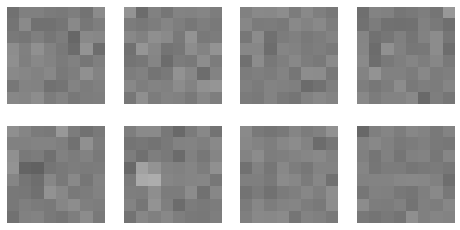

<Figure size 1440x576 with 0 Axes>

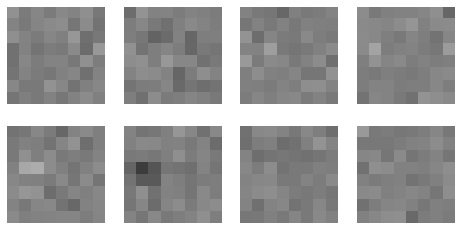

<Figure size 1440x576 with 0 Axes>

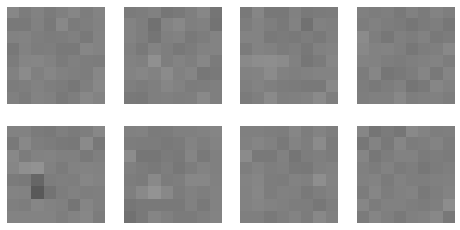

<Figure size 1440x576 with 0 Axes>

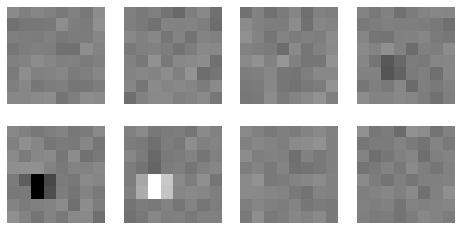

<Figure size 1440x576 with 0 Axes>

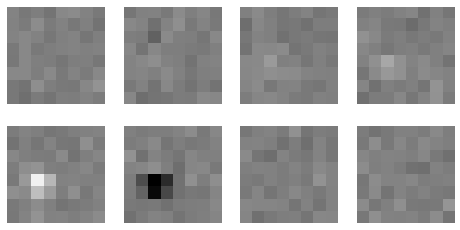

<Figure size 1440x576 with 0 Axes>

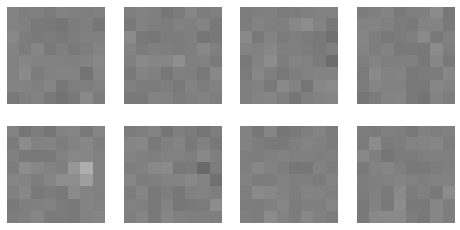

<Figure size 1440x576 with 0 Axes>

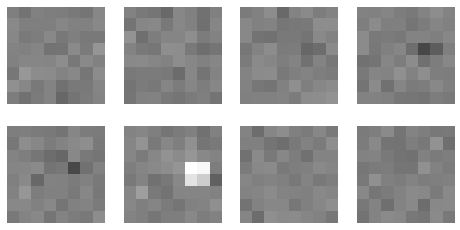

<Figure size 1440x576 with 0 Axes>

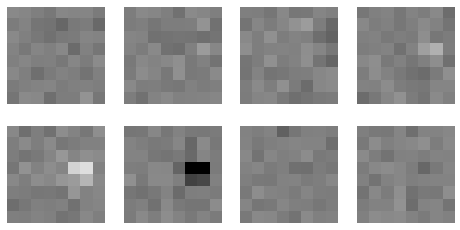

<Figure size 1440x576 with 0 Axes>

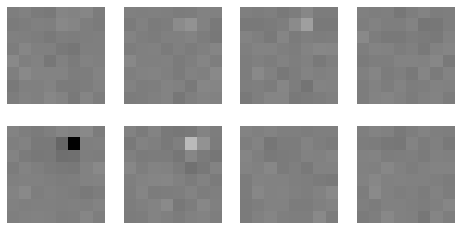

<Figure size 1440x576 with 0 Axes>

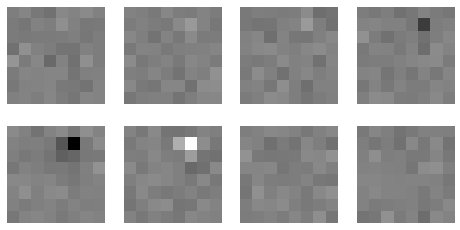

<Figure size 1440x576 with 0 Axes>

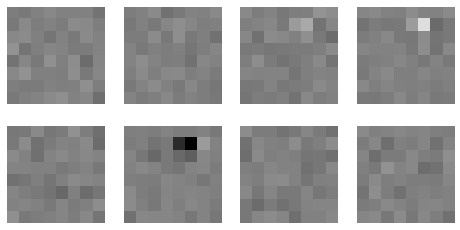

<Figure size 1440x576 with 0 Axes>

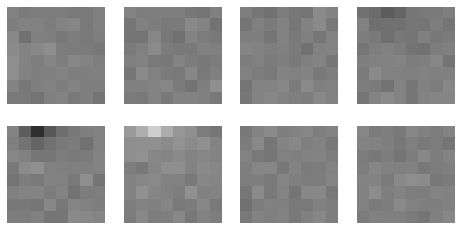

<Figure size 1440x576 with 0 Axes>

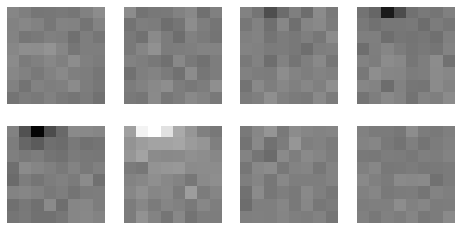

<Figure size 1440x576 with 0 Axes>

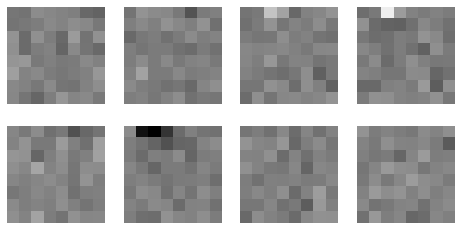

<Figure size 1440x576 with 0 Axes>

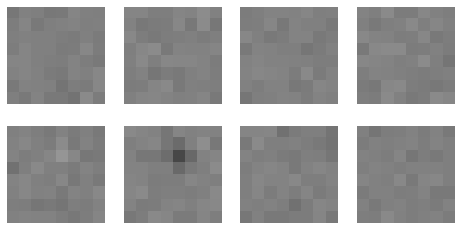

<Figure size 1440x576 with 0 Axes>

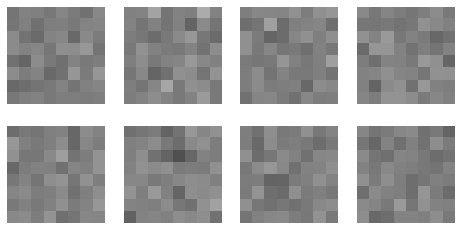

<Figure size 1440x576 with 0 Axes>

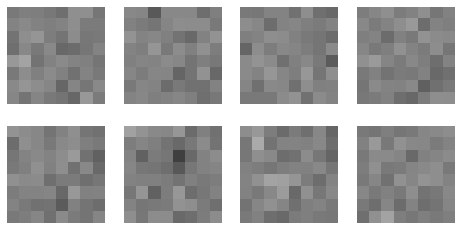

<Figure size 1440x576 with 0 Axes>

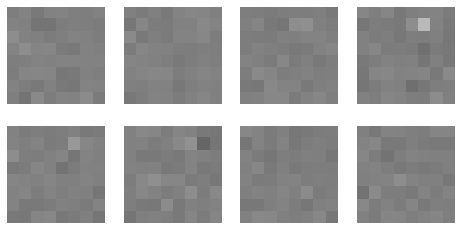

<Figure size 1440x576 with 0 Axes>

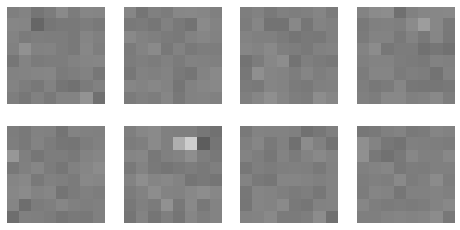

<Figure size 1440x576 with 0 Axes>

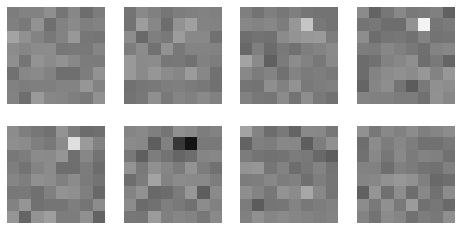

<Figure size 1440x576 with 0 Axes>

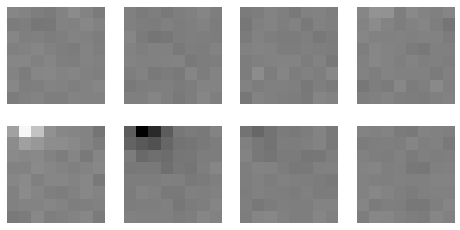

<Figure size 1440x576 with 0 Axes>

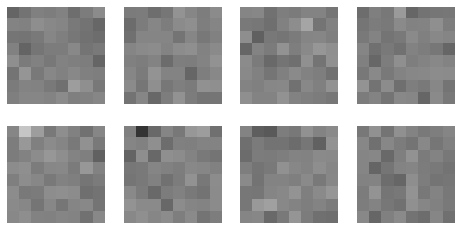

<Figure size 1440x576 with 0 Axes>

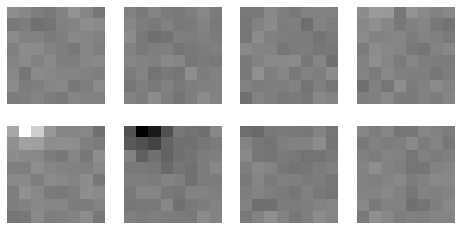

<Figure size 1440x576 with 0 Axes>

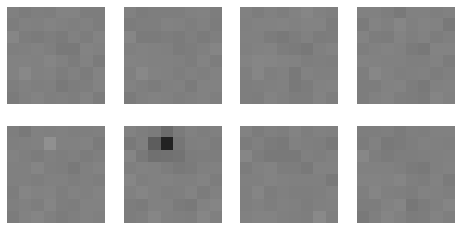

<Figure size 1440x576 with 0 Axes>

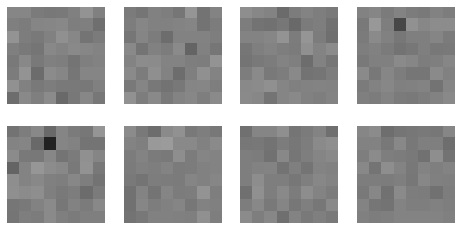

<Figure size 1440x576 with 0 Axes>

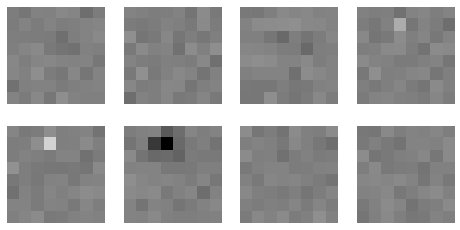

<Figure size 1440x576 with 0 Axes>

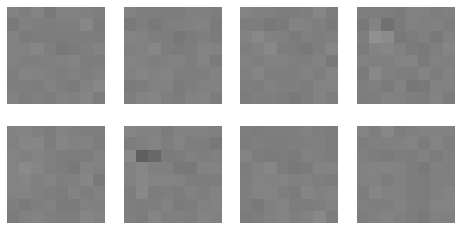

<Figure size 1440x576 with 0 Axes>

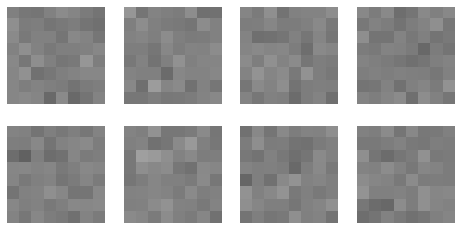

<Figure size 1440x576 with 0 Axes>

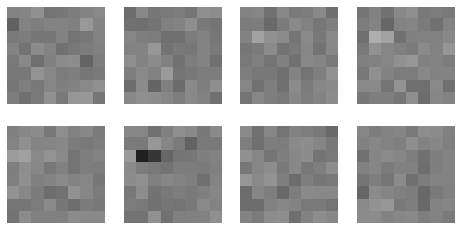

<Figure size 1440x576 with 0 Axes>

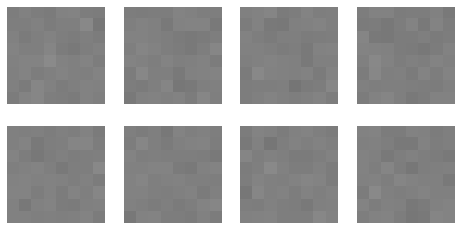

<Figure size 1440x576 with 0 Axes>

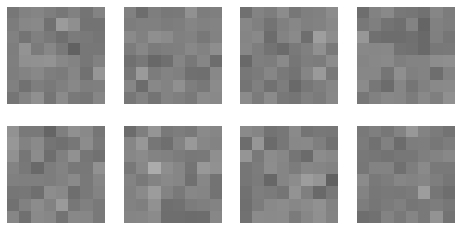

<Figure size 1440x576 with 0 Axes>

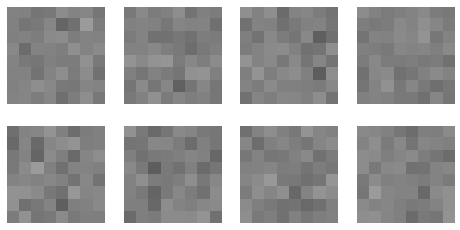

<Figure size 1440x576 with 0 Axes>

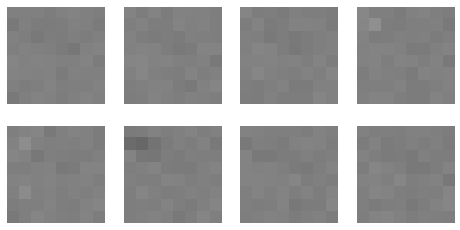

<Figure size 1440x576 with 0 Axes>

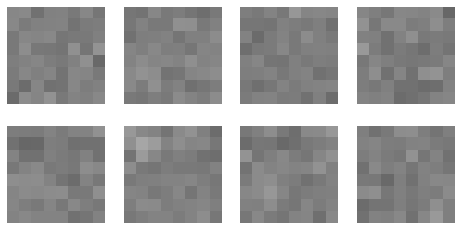

<Figure size 1440x576 with 0 Axes>

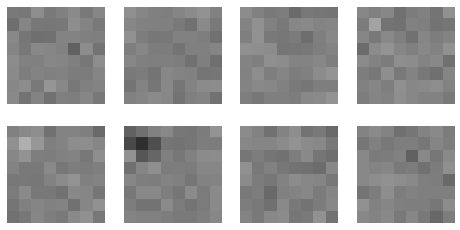

<Figure size 1440x576 with 0 Axes>

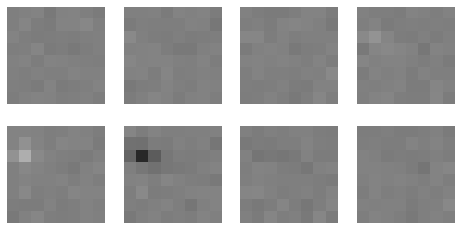

<Figure size 1440x576 with 0 Axes>

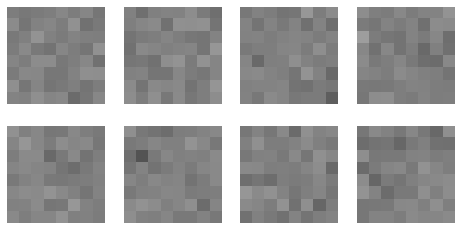

<Figure size 1440x576 with 0 Axes>

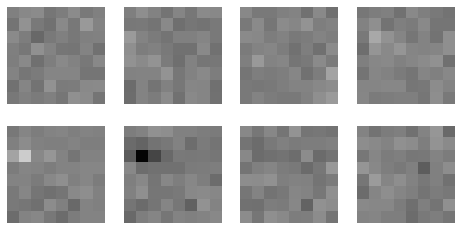

<Figure size 1440x576 with 0 Axes>

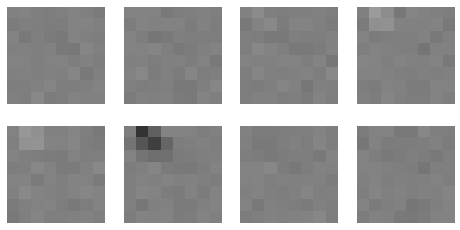

<Figure size 1440x576 with 0 Axes>

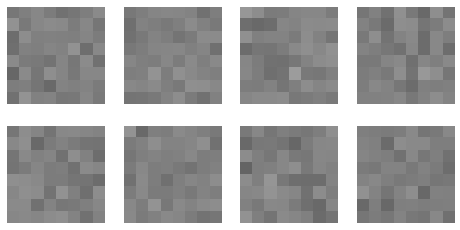

<Figure size 1440x576 with 0 Axes>

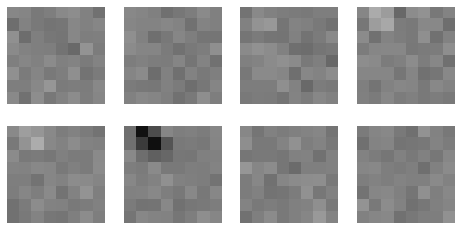

<Figure size 1440x576 with 0 Axes>

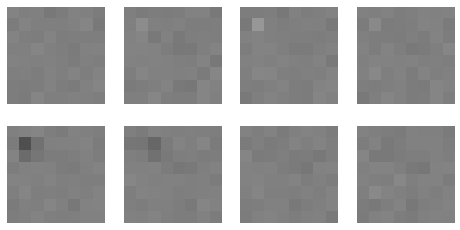

<Figure size 1440x576 with 0 Axes>

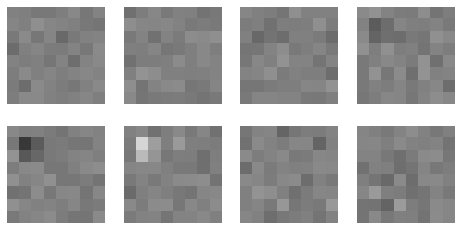

<Figure size 1440x576 with 0 Axes>

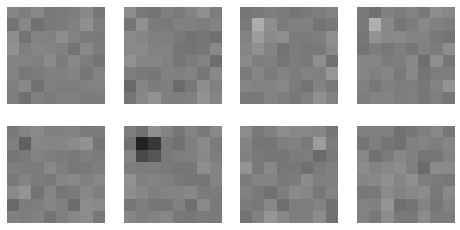

<Figure size 1440x576 with 0 Axes>

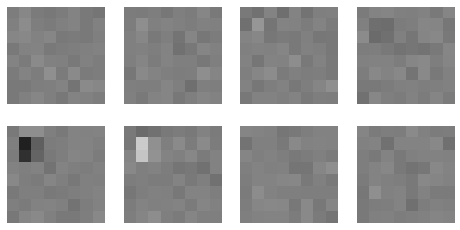

<Figure size 1440x576 with 0 Axes>

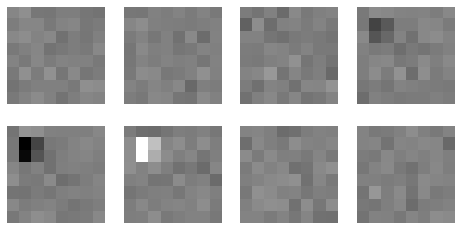

<Figure size 1440x576 with 0 Axes>

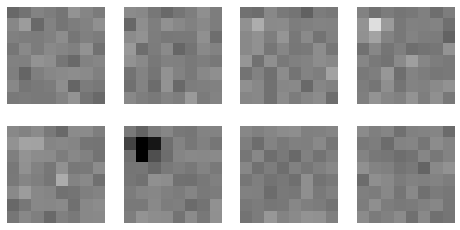

<Figure size 1440x576 with 0 Axes>

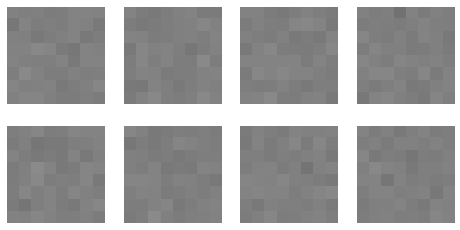

<Figure size 1440x576 with 0 Axes>

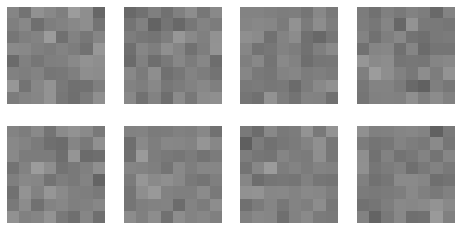

<Figure size 1440x576 with 0 Axes>

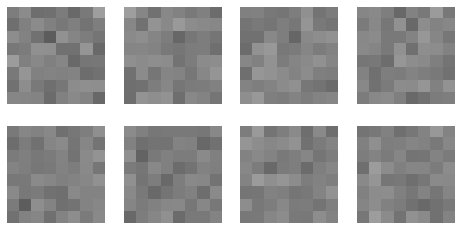

<Figure size 1440x576 with 0 Axes>

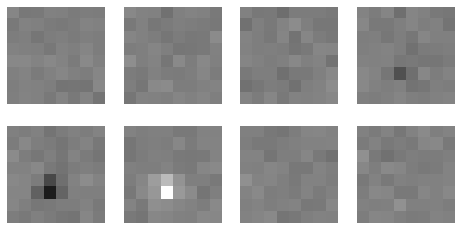

<Figure size 1440x576 with 0 Axes>

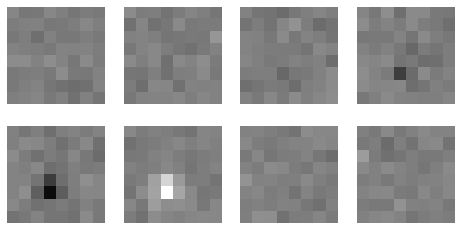

<Figure size 1440x576 with 0 Axes>

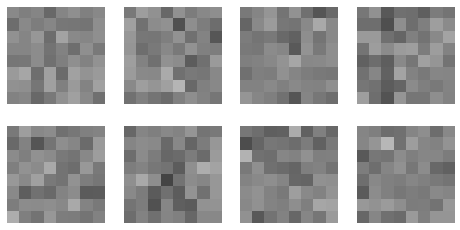

<Figure size 1440x576 with 0 Axes>

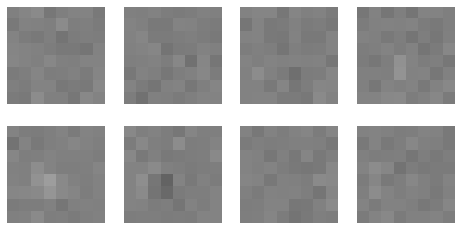

<Figure size 1440x576 with 0 Axes>

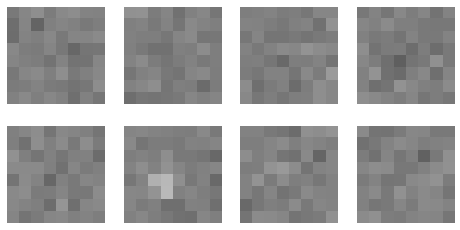

<Figure size 1440x576 with 0 Axes>

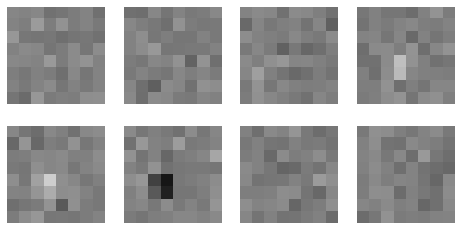

<Figure size 1440x576 with 0 Axes>

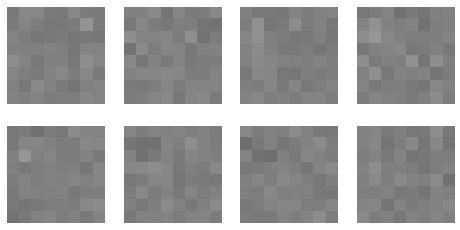

<Figure size 1440x576 with 0 Axes>

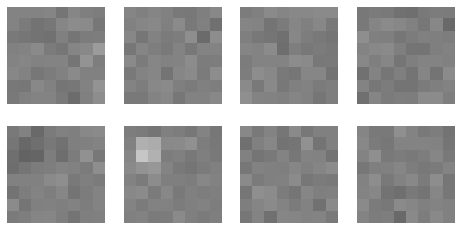

<Figure size 1440x576 with 0 Axes>

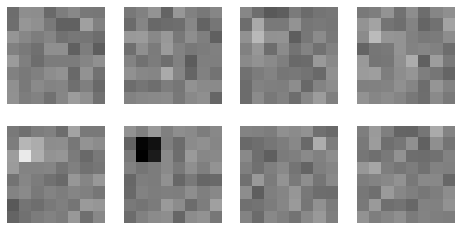

<Figure size 1440x576 with 0 Axes>

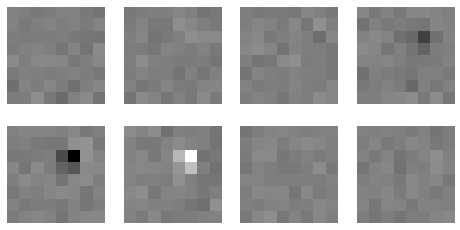

<Figure size 1440x576 with 0 Axes>

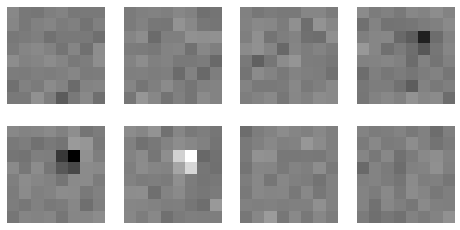

<Figure size 1440x576 with 0 Axes>

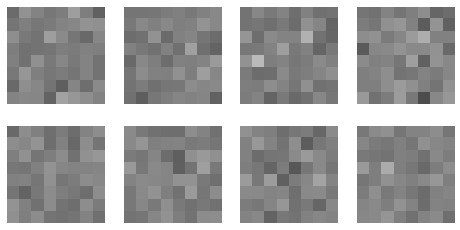

<Figure size 1440x576 with 0 Axes>

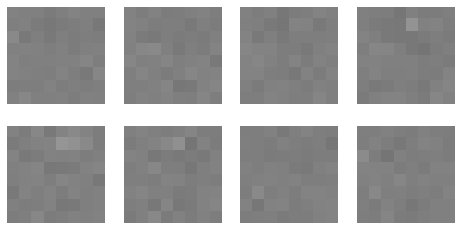

<Figure size 1440x576 with 0 Axes>

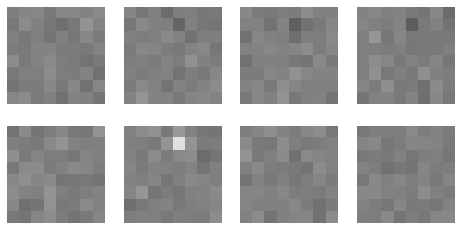

<Figure size 1440x576 with 0 Axes>

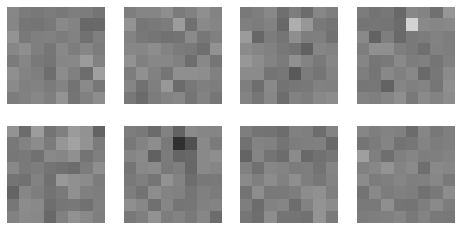

<Figure size 1440x576 with 0 Axes>

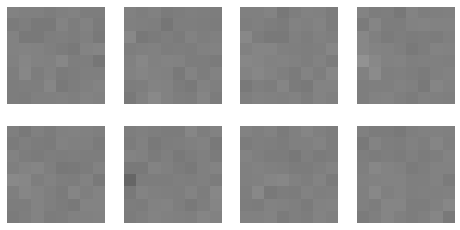

<Figure size 1440x576 with 0 Axes>

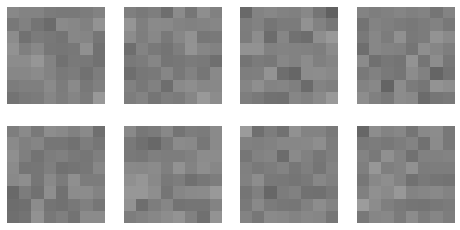

<Figure size 1440x576 with 0 Axes>

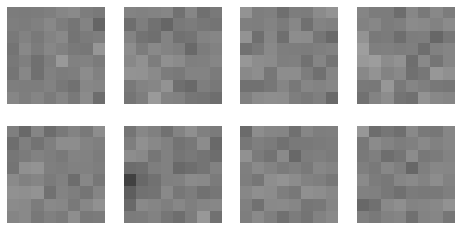

<Figure size 1440x576 with 0 Axes>

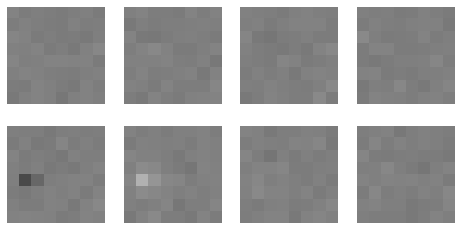

<Figure size 1440x576 with 0 Axes>

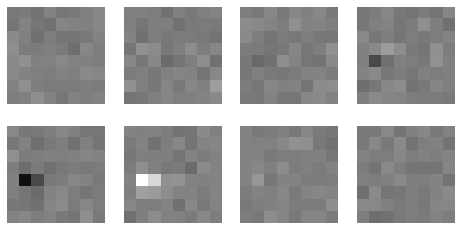

<Figure size 1440x576 with 0 Axes>

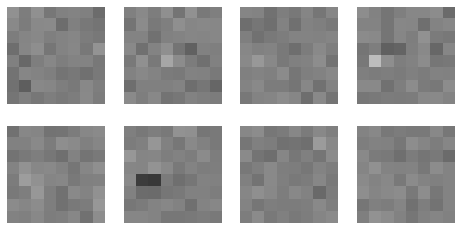

<Figure size 1440x576 with 0 Axes>

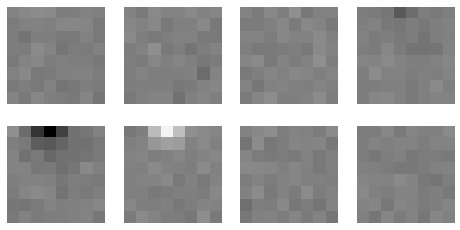

<Figure size 1440x576 with 0 Axes>

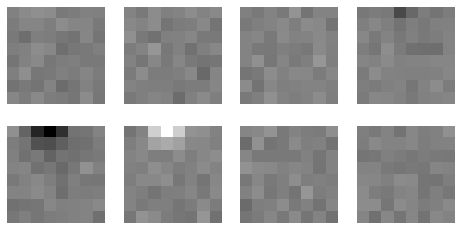

<Figure size 1440x576 with 0 Axes>

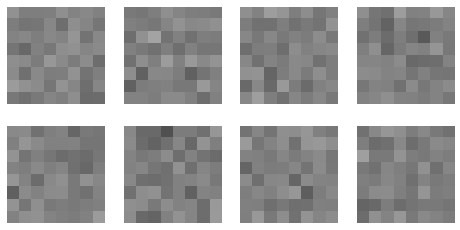

<Figure size 1440x576 with 0 Axes>

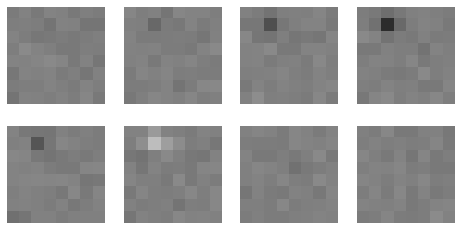

<Figure size 1440x576 with 0 Axes>

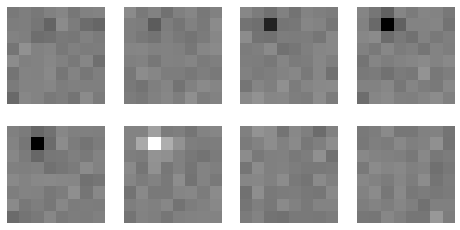

<Figure size 1440x576 with 0 Axes>

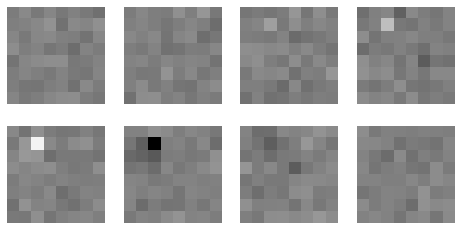

<Figure size 1440x576 with 0 Axes>

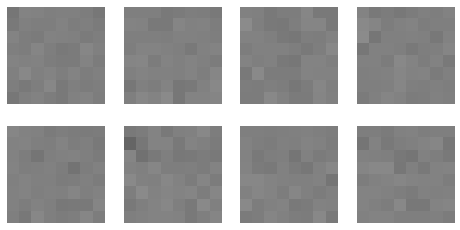

<Figure size 1440x576 with 0 Axes>

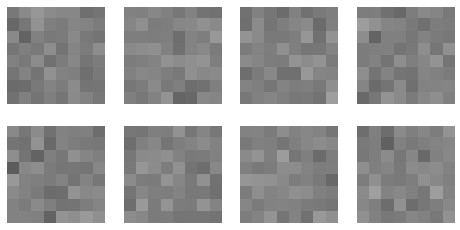

<Figure size 1440x576 with 0 Axes>

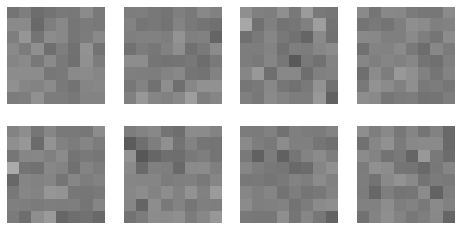

<Figure size 1440x576 with 0 Axes>

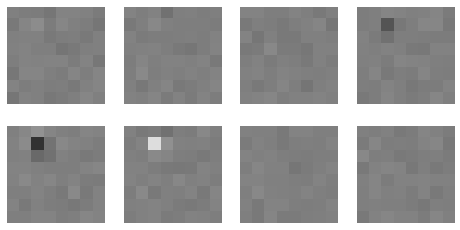

<Figure size 1440x576 with 0 Axes>

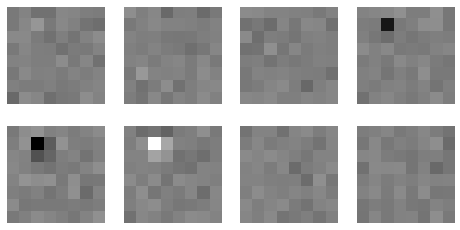

<Figure size 1440x576 with 0 Axes>

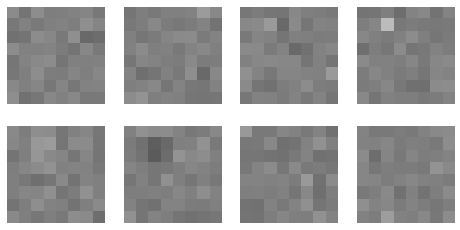

<Figure size 1440x576 with 0 Axes>

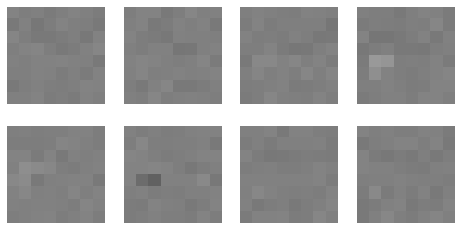

<Figure size 1440x576 with 0 Axes>

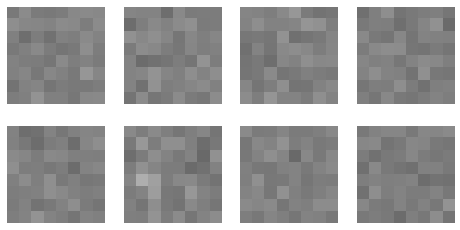

<Figure size 1440x576 with 0 Axes>

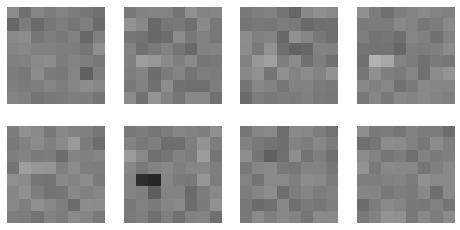

<Figure size 1440x576 with 0 Axes>

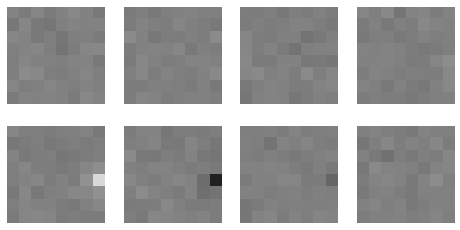

<Figure size 1440x576 with 0 Axes>

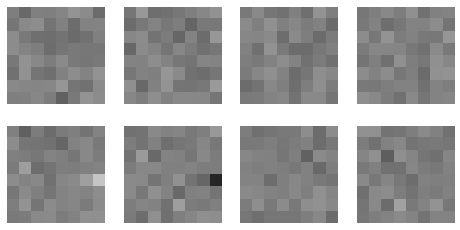

<Figure size 1440x576 with 0 Axes>

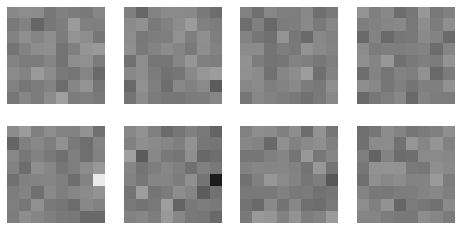

<Figure size 1440x576 with 0 Axes>

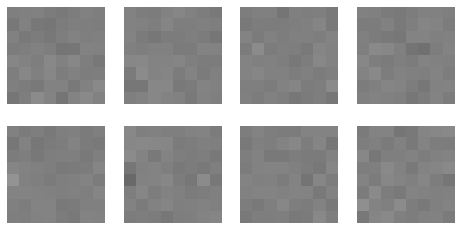

<Figure size 1440x576 with 0 Axes>

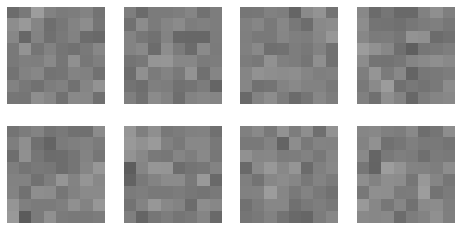

<Figure size 1440x576 with 0 Axes>

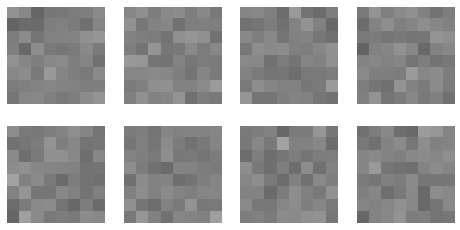

<Figure size 1440x576 with 0 Axes>

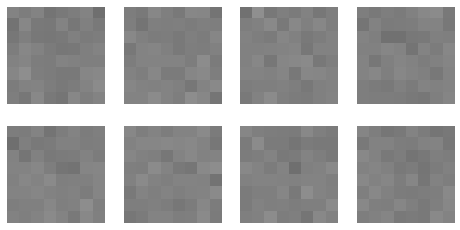

<Figure size 1440x576 with 0 Axes>

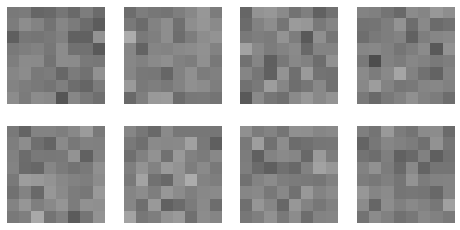

<Figure size 1440x576 with 0 Axes>

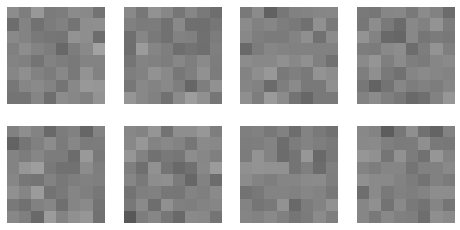

<Figure size 1440x576 with 0 Axes>

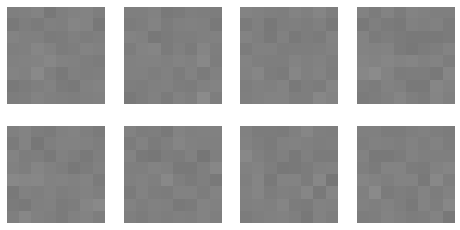

<Figure size 1440x576 with 0 Axes>

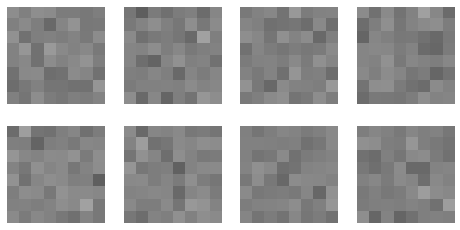

<Figure size 1440x576 with 0 Axes>

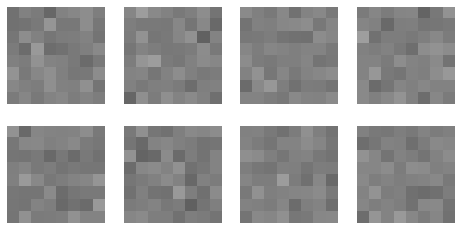

<Figure size 1440x576 with 0 Axes>

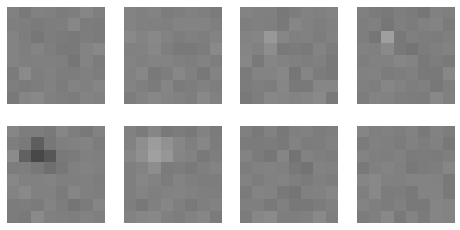

<Figure size 1440x576 with 0 Axes>

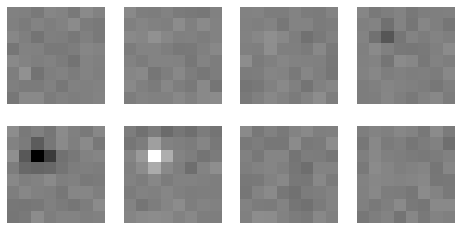

<Figure size 1440x576 with 0 Axes>

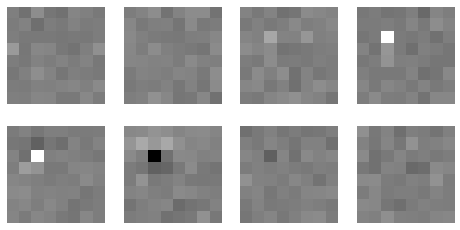

<Figure size 1440x576 with 0 Axes>

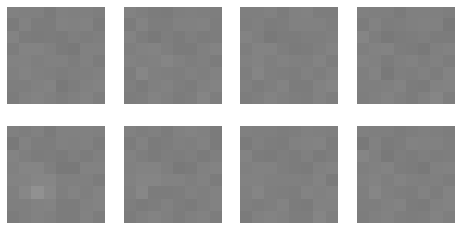

<Figure size 1440x576 with 0 Axes>

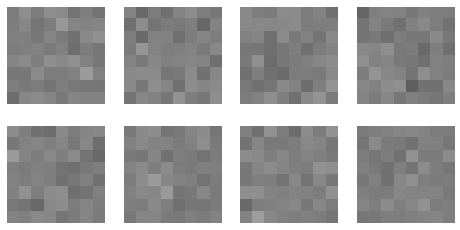

<Figure size 1440x576 with 0 Axes>

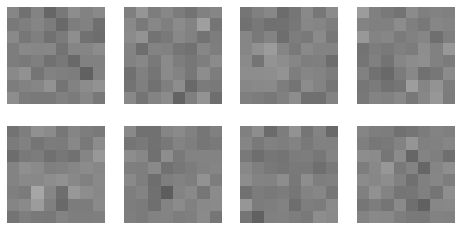

<Figure size 1440x576 with 0 Axes>

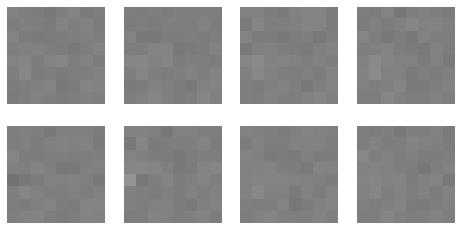

<Figure size 1440x576 with 0 Axes>

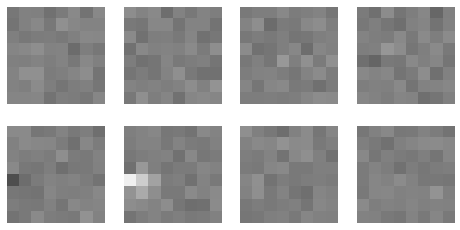

<Figure size 1440x576 with 0 Axes>

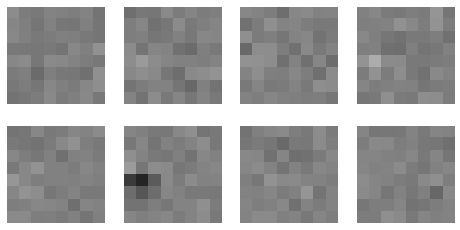

<Figure size 1440x576 with 0 Axes>

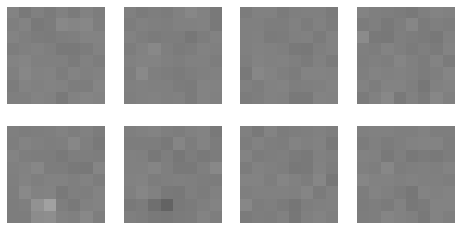

<Figure size 1440x576 with 0 Axes>

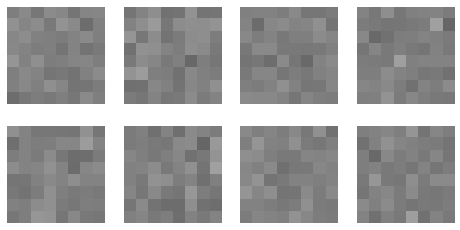

<Figure size 1440x576 with 0 Axes>

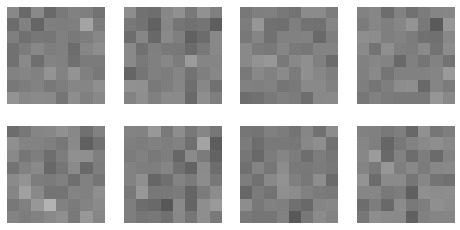

<Figure size 1440x576 with 0 Axes>

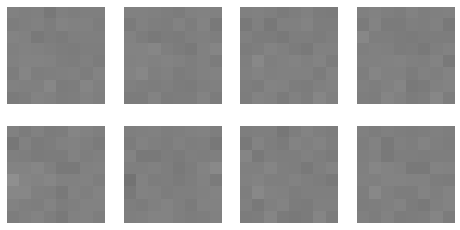

<Figure size 1440x576 with 0 Axes>

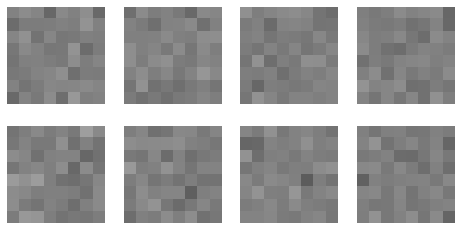

<Figure size 1440x576 with 0 Axes>

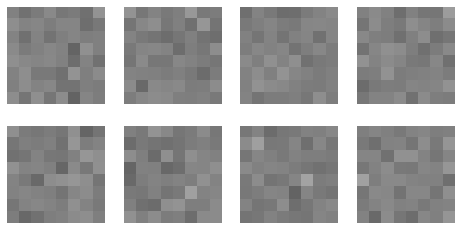

<Figure size 1440x576 with 0 Axes>

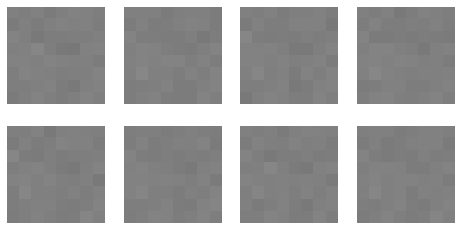

<Figure size 1440x576 with 0 Axes>

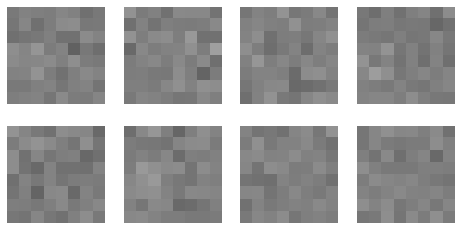

<Figure size 1440x576 with 0 Axes>

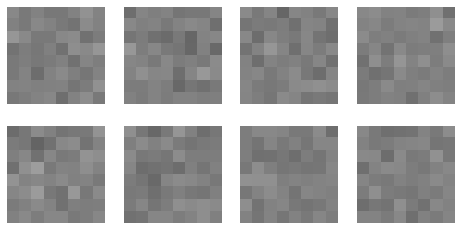

<Figure size 1440x576 with 0 Axes>

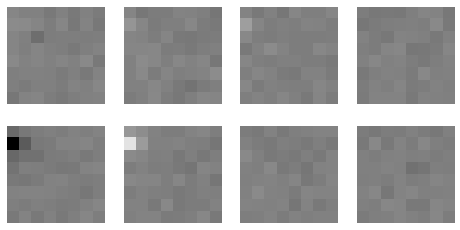

<Figure size 1440x576 with 0 Axes>

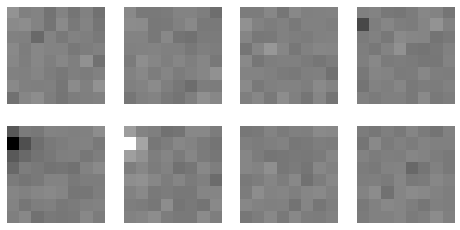

<Figure size 1440x576 with 0 Axes>

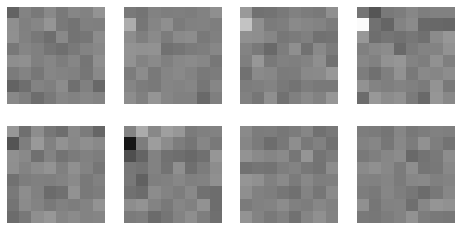

<Figure size 1440x576 with 0 Axes>

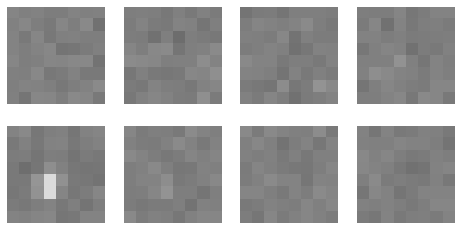

<Figure size 1440x576 with 0 Axes>

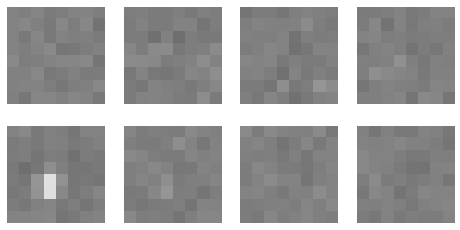

<Figure size 1440x576 with 0 Axes>

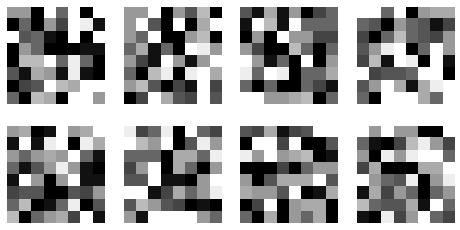

<Figure size 1440x576 with 0 Axes>

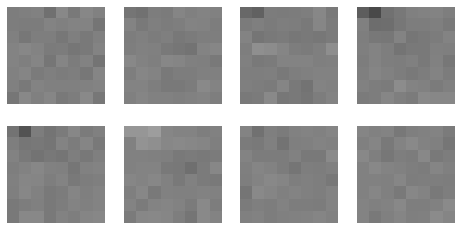

<Figure size 1440x576 with 0 Axes>

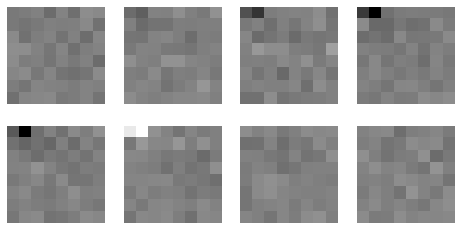

<Figure size 1440x576 with 0 Axes>

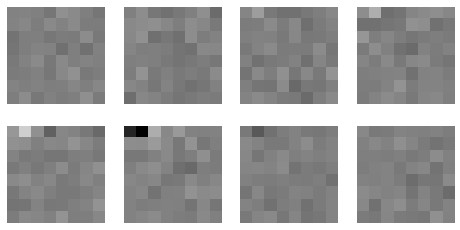

<Figure size 1440x576 with 0 Axes>

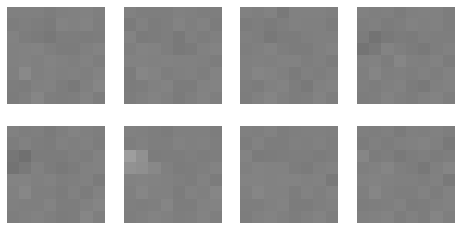

<Figure size 1440x576 with 0 Axes>

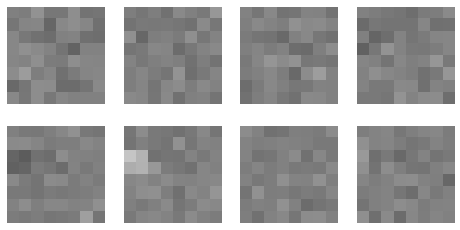

<Figure size 1440x576 with 0 Axes>

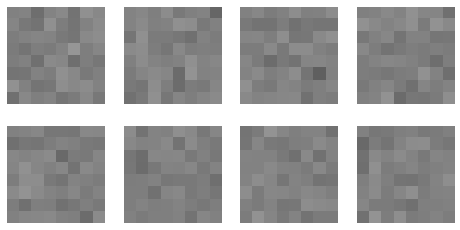

<Figure size 1440x576 with 0 Axes>

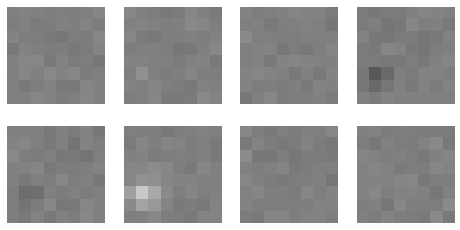

<Figure size 1440x576 with 0 Axes>

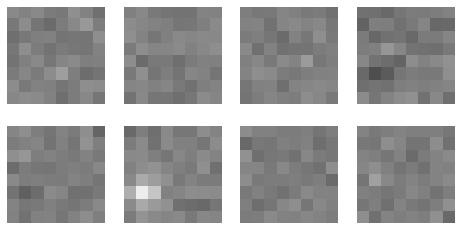

<Figure size 1440x576 with 0 Axes>

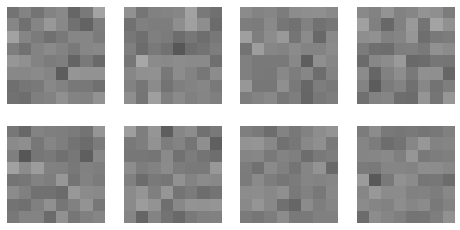

<Figure size 1440x576 with 0 Axes>

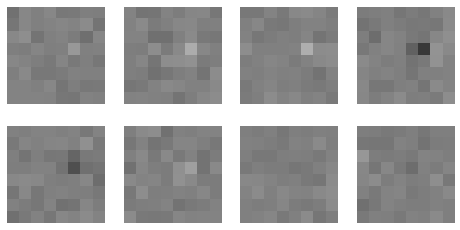

<Figure size 1440x576 with 0 Axes>

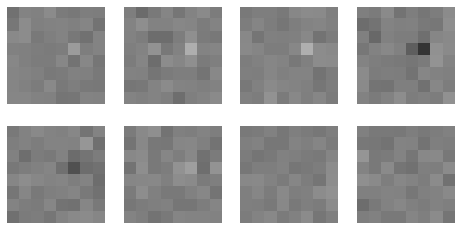

<Figure size 1440x576 with 0 Axes>

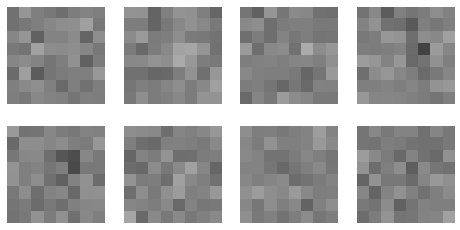

<Figure size 1440x576 with 0 Axes>

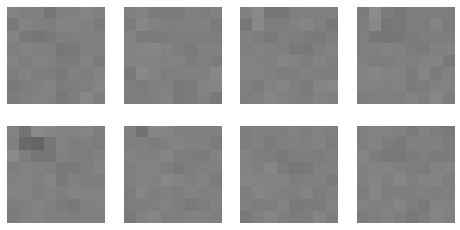

<Figure size 1440x576 with 0 Axes>

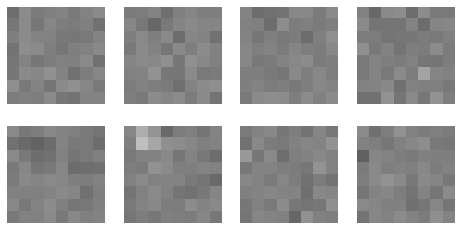

<Figure size 1440x576 with 0 Axes>

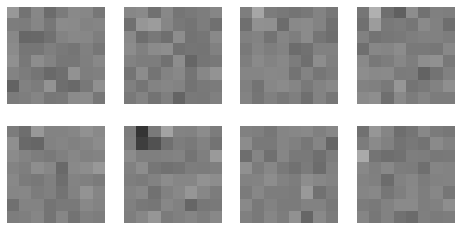

<Figure size 1440x576 with 0 Axes>

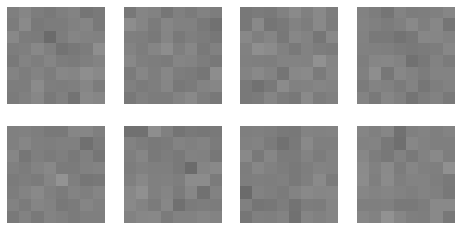

<Figure size 1440x576 with 0 Axes>

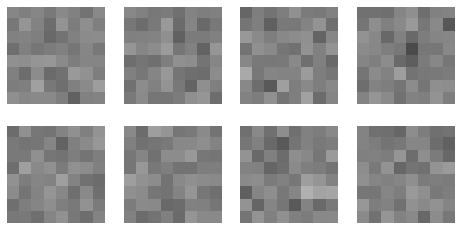

<Figure size 1440x576 with 0 Axes>

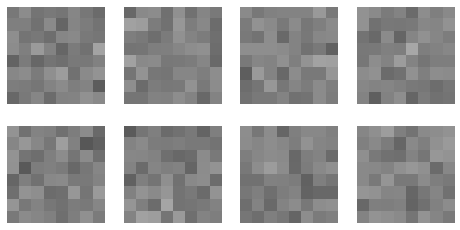

<Figure size 1440x576 with 0 Axes>

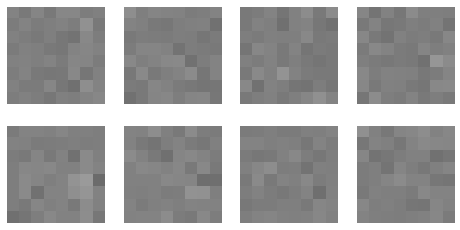

<Figure size 1440x576 with 0 Axes>

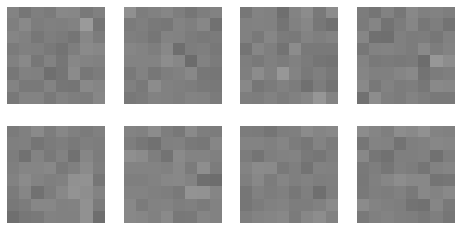

<Figure size 1440x576 with 0 Axes>

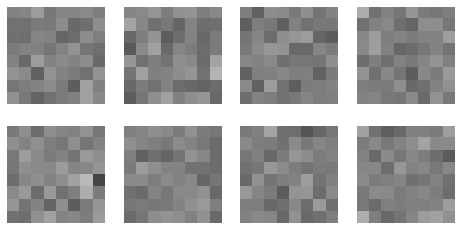

<Figure size 1440x576 with 0 Axes>

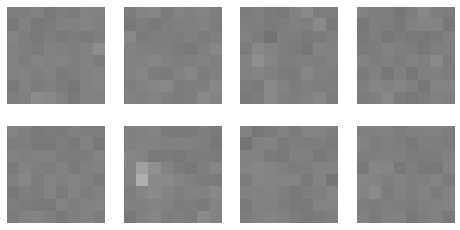

<Figure size 1440x576 with 0 Axes>

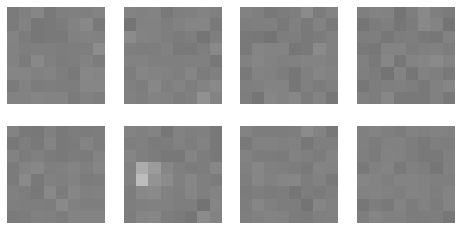

<Figure size 1440x576 with 0 Axes>

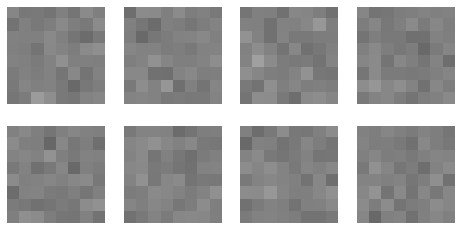

<Figure size 1440x576 with 0 Axes>

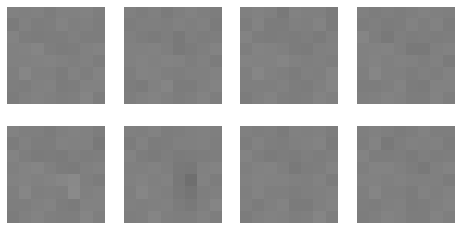

<Figure size 1440x576 with 0 Axes>

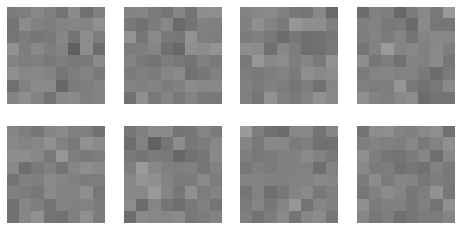

<Figure size 1440x576 with 0 Axes>

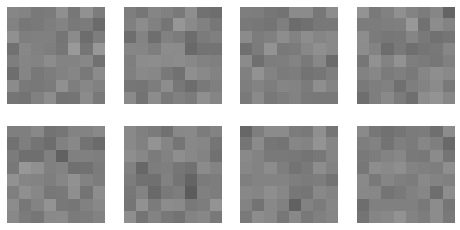

<Figure size 1440x576 with 0 Axes>

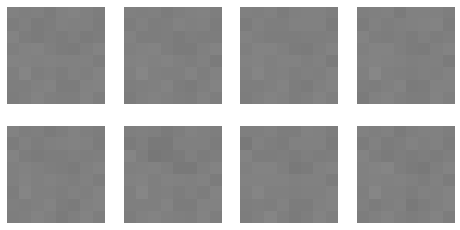

<Figure size 1440x576 with 0 Axes>

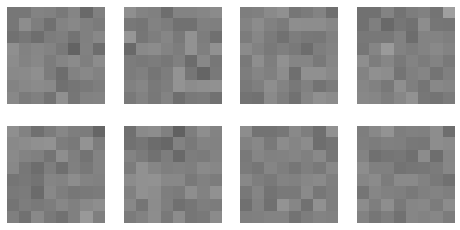

<Figure size 1440x576 with 0 Axes>

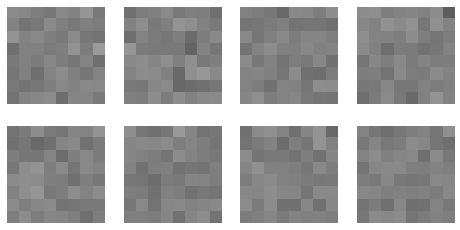

<Figure size 1440x576 with 0 Axes>

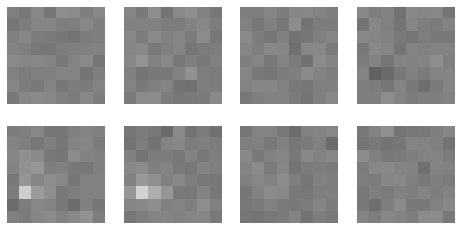

<Figure size 1440x576 with 0 Axes>

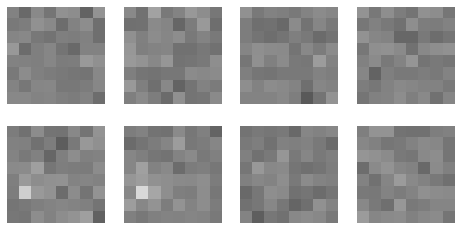

<Figure size 1440x576 with 0 Axes>

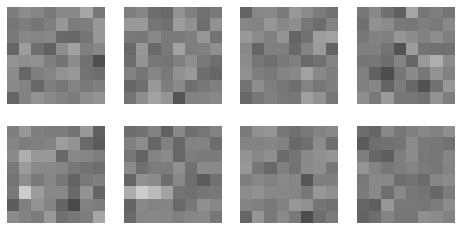

<Figure size 1440x576 with 0 Axes>

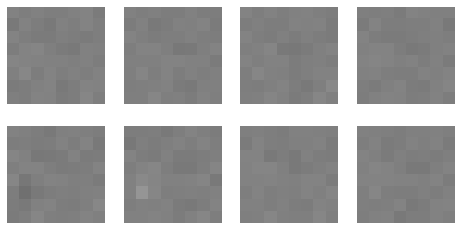

<Figure size 1440x576 with 0 Axes>

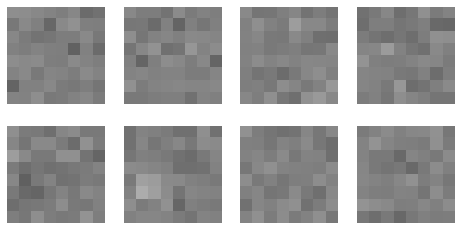

<Figure size 1440x576 with 0 Axes>

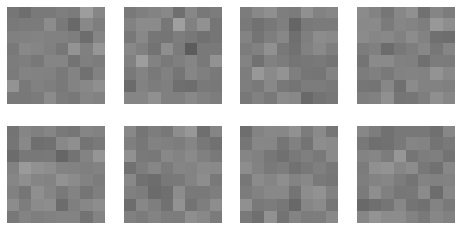

<Figure size 1440x576 with 0 Axes>

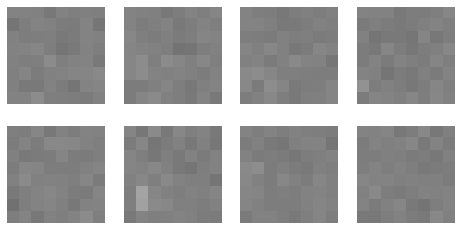

<Figure size 1440x576 with 0 Axes>

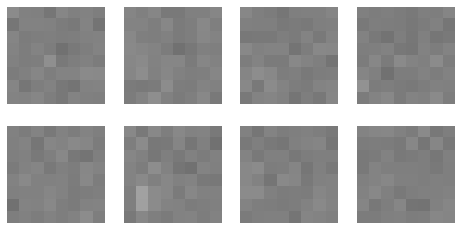

<Figure size 1440x576 with 0 Axes>

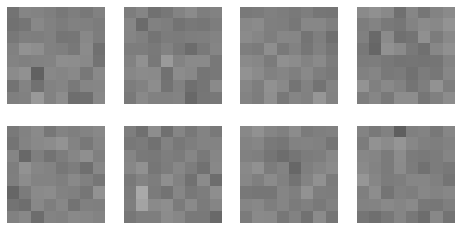

<Figure size 1440x576 with 0 Axes>

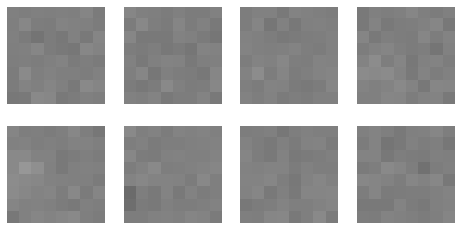

<Figure size 1440x576 with 0 Axes>

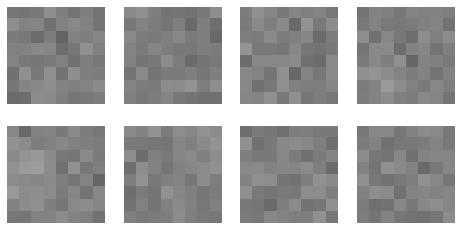

<Figure size 1440x576 with 0 Axes>

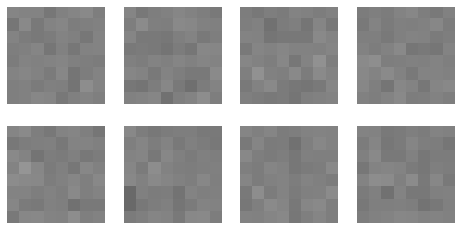

<Figure size 1440x576 with 0 Axes>

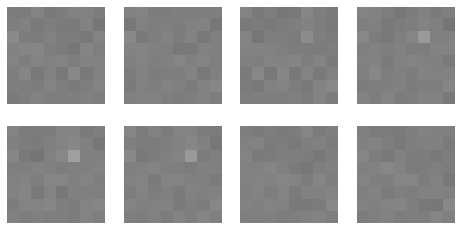

<Figure size 1440x576 with 0 Axes>

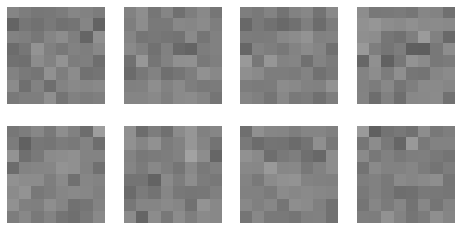

<Figure size 1440x576 with 0 Axes>

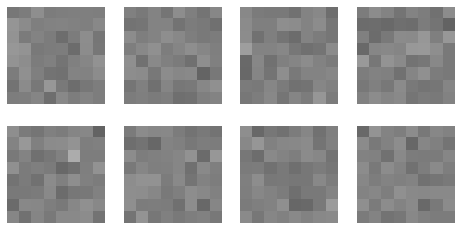

<Figure size 1440x576 with 0 Axes>

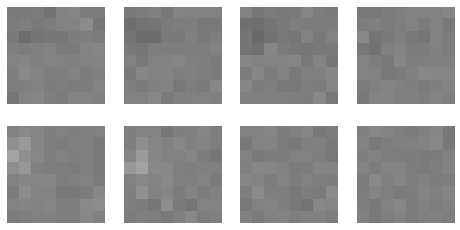

<Figure size 1440x576 with 0 Axes>

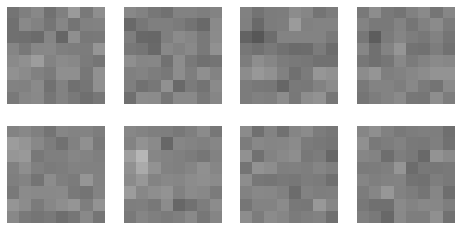

<Figure size 1440x576 with 0 Axes>

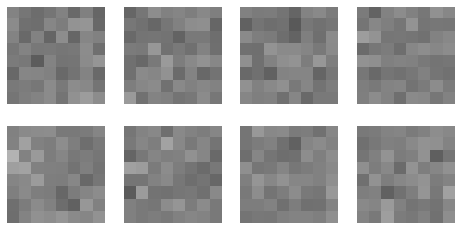

<Figure size 1440x576 with 0 Axes>

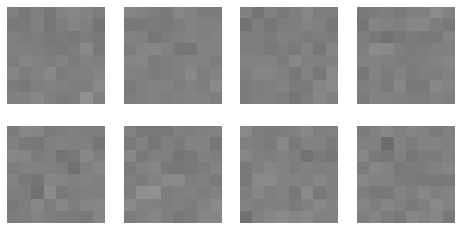

<Figure size 1440x576 with 0 Axes>

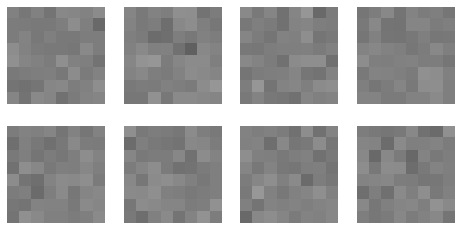

<Figure size 1440x576 with 0 Axes>

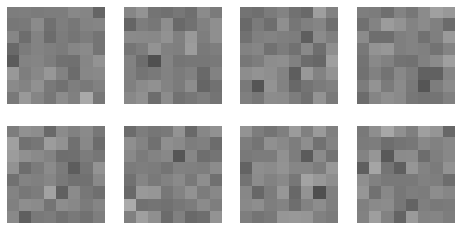

<Figure size 1440x576 with 0 Axes>

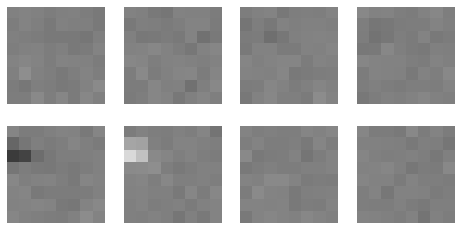

<Figure size 1440x576 with 0 Axes>

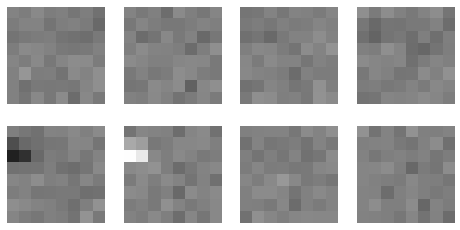

<Figure size 1440x576 with 0 Axes>

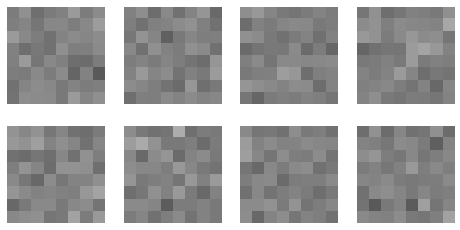

<Figure size 1440x576 with 0 Axes>

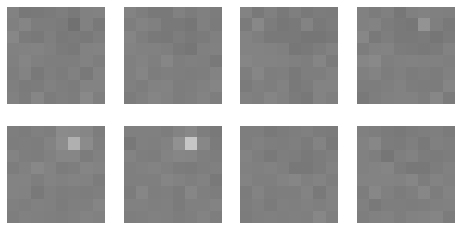

<Figure size 1440x576 with 0 Axes>

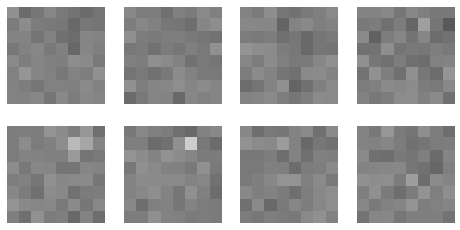

<Figure size 1440x576 with 0 Axes>

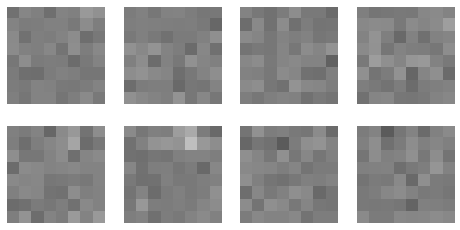

<Figure size 1440x576 with 0 Axes>

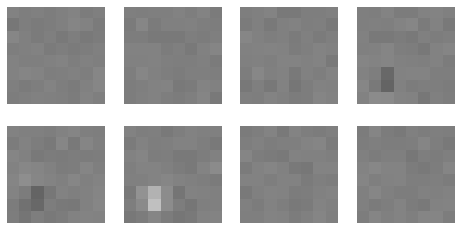

<Figure size 1440x576 with 0 Axes>

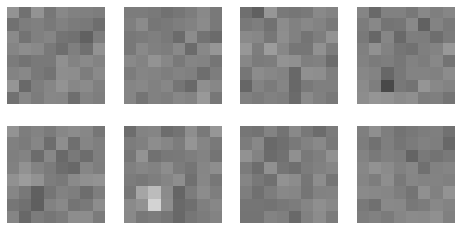

<Figure size 1440x576 with 0 Axes>

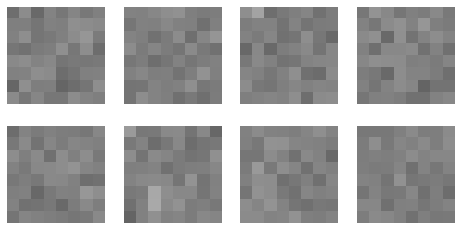

<Figure size 1440x576 with 0 Axes>

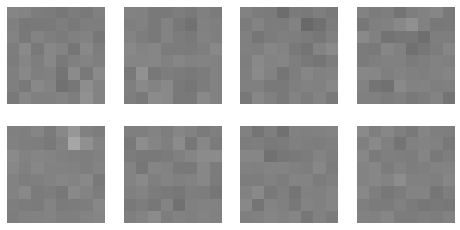

<Figure size 1440x576 with 0 Axes>

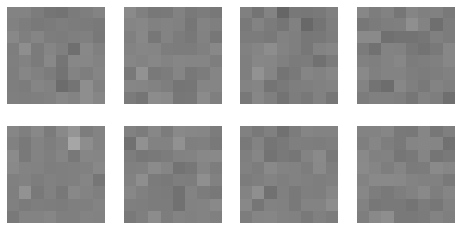

<Figure size 1440x576 with 0 Axes>

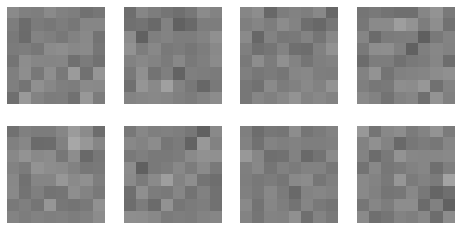

In [26]:
stcl.plot_examples(cluster_on_and_off, cluster_dim, 
                   folder_name="cluster_dim{}_on_and_off_by_cnn_temp".format(cluster_dim),
                   temporal_profile=True, spatial_profile=False)
stcl.plot_examples(cluster_on_and_off, cluster_dim, 
                   folder_name="cluster_dim{}_on_and_off_by_cnn_spatial".format(cluster_dim),
                   temporal_profile=False, spatial_profile=True)

## manually check using saved temporal profiles

channel_name                 13c
num_spikes                  2914
cell_type                     ON
PSNR                     19.0323
eig1                    0.567682
eig2                    0.543163
eig3                     0.53687
converged                   True
PSNR1                    16.5318
PSNR2                    6.21186
weight1                 0.583156
weight2                 0.416844
inner_product          -0.215672
dataset                 20180621
cell_type_on_and_off      ON/OFF
cell_type_prob0          0.99991
cell_type_prob1         0.999508
cell_type_prob2         0.363525
logit                    1.45917
abs_logit                1.45917
Name: 121, dtype: object

<Figure size 1440x576 with 0 Axes>

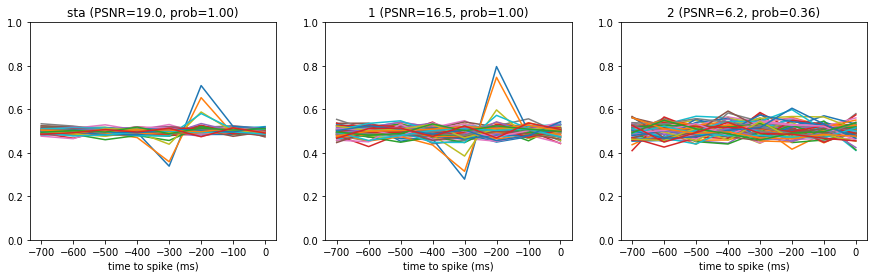

<Figure size 1440x576 with 0 Axes>

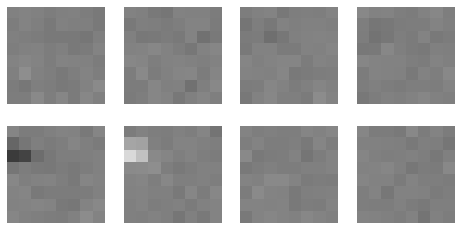

<Figure size 1440x576 with 0 Axes>

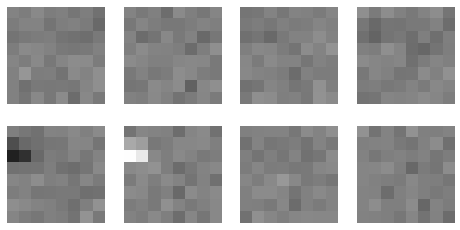

<Figure size 1440x576 with 0 Axes>

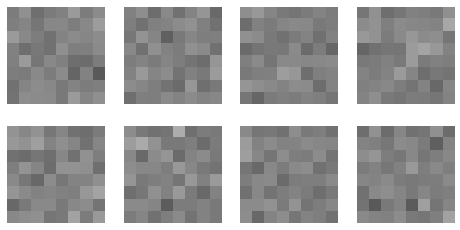

In [27]:
idx = 60

folder_name = "cluster_dim{}_on_and_off_by_cnn_manual".format(cluster_dim)

stcl.plot_an_example(cluster_on_and_off.iloc[idx], cluster_dim, 
                     temporal_profile=True, spatial_profile=True,
                     folder_name = folder_name)
cluster_on_and_off.iloc[idx]


In [28]:
# manual inspection


if cluster_dim==2:
    if spike_per_dim == 2:
        idx_checked = [0, 1, 2, 3, 4, 5, 6, 8,
                       10, 11, 13, 16, 17,
                       20, 21, 23, 25, 26, 27, 29, 
                       30, 35, 37,
                       41, 43, 47,]            
elif cluster_dim==3:
    pass
else:
    pass

cluster_on_and_off_checked = cluster_on_and_off.iloc[idx_checked]
cluster_on_and_off_checked["cell_type_on_and_off_checked"]=True


# cluster_checked.loc["on_and_off"]=True



cluster_on_and_off_checked.to_csv("cluster_dim{}_on_and_off_by_cnn_checked.csv".format(cluster_dim), index=None)

print(len(cluster_on_and_off_checked))

# plot_inner_product_vs_eig1(cluster_on_and_off_checked)

26


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
# plt.figure(figsize=(7,15))
# plt.subplot(311)
# plot_inner_product_vs_eig1(cluster_with_enough_spikes)
# plt.xlim([-0.6, 0])
# # plt.subplot(312)
# # plot_inner_product_vs_eig1(cluster_thresholded)
# # plt.xlim([-0.6, 0])
# plt.subplot(313)
# plot_inner_product_vs_eig1(cluster_on_and_off_checked)
# plt.xlim([-0.6, 0])

In [51]:
cluster_on_and_off_checked

channel_name  num_spikes cell_type       PSNR      eig1      eig2  \
300          37b        9568       OFF  18.715314  0.542621  0.476537   
175          42b        8472        ON  21.819161  0.567641  0.502737   
139          25a       26155   unknown  10.224226  0.422080  0.414922   
297          36c        4098   unknown  10.318830  0.798256  0.620102   
227          85b        4002        ON  11.494061  0.678136  0.597015   
355          71b        7557        ON  23.712959  0.575136  0.510658   
38           32b        3530        ON  16.838700  0.862429  0.749463   
356          71c        2912        ON  13.760327  0.630695  0.600578   
171          41a       16997       OFF  19.648014  0.450724  0.432585   
135          23a       13447   unknown  12.650385  0.456403  0.445747   
153          33a       14055   unknown  10.983452  0.429599  0.423111   
132          22b       15606       OFF  16.500673  0.443572  0.439005   
257          22a        2860        ON  17.556724  0.838246  0.704459   
319          46b        2762       OFF  10.083432  0.592556  0.580456   
258          22b        2413   unknown   6.267735  0.835159  0.782430   
195          61a        6741   unknown   7.826017  0.497795  0.488286   
144          26c        6699        ON  20.090976  0.498963  0.470083   
55           42b        3937        ON  21.174844  0.768183  0.649924   
43           34b        4208        ON  18.520772  0.706069  0.597161   
151          32a       11842        ON  23.692912  0.544881  0.489408   
143          26b        9808   unknown  12.890620  0.461932  0.457962   
44           35a        9638        ON  13.477084  0.665520  0.552200   
124          16a       22460   unknown   9.654894  0.448151  0.420615   
7            14a        5973        ON  25.775064  0.620785  0.571746   
22           23b        4619        ON  11.990694  0.700543  0.608037   
130          21b       10519   unknown   9.359431  0.466609  0.459186   

         eig3  converged      PSNR1      PSNR2  ...   weight2  inner_product  \
300  0.469468       True  20.694819  15.913280  ...  0.481502      -0.303349   
175  0.496190       True  22.212132  13.903167  ...  0.459419      -0.278880   
139  0.406125       True   7.759385  10.137703  ...  0.494726      -0.242051   
297  0.613533       True  18.892517  18.855896  ...  0.475879      -0.555696   
227  0.581718       True  15.846811  14.866739  ...  0.484177      -0.394200   
355  0.508055       True  25.080139  19.315994  ...  0.458082      -0.263436   
38   0.716215       True  17.936124  14.497231  ...  0.352354      -0.449921   
356  0.589766       True  13.720303  13.828661  ...  0.567049      -0.139315   
171  0.428108       True  21.252288  11.938636  ...  0.466289      -0.220492   
135  0.437169       True  11.757749   6.666435  ...  0.508151      -0.241768   
153  0.422443       True   6.441576  11.627309  ...  0.501978      -0.242415   
132  0.435544       True  12.984921  13.880398  ...  0.489015      -0.234519   
257  0.671715       True  18.716530  14.826105  ...  0.352635      -0.479533   
319  0.562291       True  12.540200   8.637063  ...  0.497645      -0.284796   
258  0.732217       True  12.865903  10.592013  ...  0.619188      -0.312358   
195  0.475730       True  12.518911  14.101404  ...  0.532423      -0.247584   
144  0.461593       True  19.790906  12.163867  ...  0.466892      -0.267992   
55   0.644162       True  20.801417   6.320643  ...  0.361816      -0.209661   
43   0.588002       True  21.493398  19.136803  ...  0.433527      -0.375909   
151  0.483369       True  21.754861   9.931059  ...  0.476116      -0.237349   
143  0.452622       True  11.259656   7.187335  ...  0.499561      -0.241998   
44   0.548982       True  25.869758  22.670575  ...  0.446696      -0.437553   
124  0.417214       True  12.633903  14.917845  ...  0.492122      -0.260887   
7    0.562778       True  25.702134  15.884281  ...  0.401470      -0.206751   
22   0.595794       True  17.952

In [67]:
## check statistics
cluster_combined = cluster_with_enough_spikes
# cluster_combined["cell_type_clustered"]=cluster_combined["cell_type"]
cluster_combined = cluster_combined.merge(cluster_on_and_off_checked[["dataset", "channel_name","cell_type_on_and_off_checked"]], on=["dataset", "channel_name"], how="outer")

# not checked is False
idx_null = cluster_combined["cell_type_on_and_off_checked"].isnull()
cluster_combined.loc[idx_null, "cell_type_on_and_off_checked"] = False

# combine original cell_type
cluster_combined["cell_type_combined"] = cluster_combined["cell_type"]
cluster_combined.loc[~idx_null,"cell_type_combined"] = "ON/OFF"

cluster_combined

channel_name  num_spikes cell_type       PSNR      eig1      eig2  \
0            12a        1978       OFF  12.186541  0.971392  0.754007   
1            12b        1228        ON   9.526389  0.920008  0.895442   
2            14a        5973        ON  25.775064  0.620785  0.571746   
3            14b        1212        ON  11.186482  0.795804  0.766490   
4            17a        5929   unknown   8.452868  0.436700  0.434049   
..           ...         ...       ...        ...       ...       ...   
213          83b        1300       OFF  14.727492  0.879242  0.851718   
214          86a        3186        ON  19.576154  0.952703  0.766365   
215          86b        1684   unknown   6.779709  0.788005  0.759195   
216          87a        9120       OFF  21.676952  0.590420  0.517161   
217          87b        3797        ON  16.662341  0.487358  0.482080   

         eig3  converged      PSNR1      PSNR2  ...  inner_product   dataset  \
0    0.737358       True  11.450823  10.235904  ...       0.420599  20180618   
1    0.871839       True   9.419680   7.839765  ...       0.255689  20180618   
2    0.562778       True  25.702134  15.884281  ...      -0.206751  20180618   
3    0.746218       True  11.501885  10.593278  ...      -0.076766  20180618   
4    0.430598       True   6.269053   5.988208  ...      -0.251180  20180618   
..        ...        ...        ...        ...  ...            ...       ...   
213  0.813824       True  14.368050  10.560972  ...       0.310200  20180626   
214  0.749286       True   9.892318  19.695189  ...       0.588351  20180626   
215  0.735989       True   6.928302   6.117002  ...      -0.003025  20180626   
216  0.512286       True  19.043271  14.230278  ...       0.056832  20180626   
217  0.475510       True   9.090881  12.160747  ...      -0.128974  20180626   

     cell_type_on_and_off cell_type_prob0 cell_type_prob1  cell_type_prob2  \
0                 unknown        0.007388        0.007968         0.008210   
1                 unknown        1.000000        0.999998         0.999965   
2                  ON/OFF        0.932818        0.967521         0.082154   
3                 unknown        0.999931        0.998910         0.982262   
4                  ON/OFF        0.051133        0.529524         0.043180   
..                    ...             ...             ...              ...   
213               unknown        0.014045        0.016215         0.014596   
214               unknown        0.996241        0.967424         0.995182   
215                ON/OFF        0.946782        0.187967         0.977177   
216               unknown        0.012749        0.015899         0.019359   
217               unknown        0.999258        0.766921         0.997713   

        logit  abs_logit  cell_type_on_and_off_checked  cell_type_combined  
0   -0.043210   0.043210                         False                 OFF  
1    0.000047   0.000047                         False                  ON  
2    3.557893   3.557893                          True              ON/OFF  
3    0.024247   0.024247                         False                  ON  
4    3.616265   3.616265                         False             unknown  
..        ...        ...                           ...                 ...  
213  0.151714   0.151714                         False                 OFF  
214 -0.040813   0.040813                         False                  ON  
215 -2.378143   2.378143                         False             unknown  
216 -0.284050   0.284050                         False                 OFF  
217 -0.379547   0.379547                         False                  ON  

[218 rows x 22 columns]

In [68]:
print(cluster_combined["cell_type"].value_counts())
print(cluster_combined["cell_type"].value_counts() / len(cluster_combined))

OFF        107
ON          63
unknown     48
Name: cell_type, dtype: int64
OFF        0.490826
ON         0.288991
unknown    0.220183
Name: cell_type, dtype: float64


In [69]:
print(cluster_combined["cell_type_combined"].value_counts())
print(cluster_combined["cell_type_combined"].value_counts() / len(cluster_combined))

OFF        103
ON          50
unknown     39
ON/OFF      26
Name: cell_type_combined, dtype: int64
OFF        0.472477
ON         0.229358
unknown    0.178899
ON/OFF     0.119266
Name: cell_type_combined, dtype: float64


In [70]:
cluster_combined.groupby("cell_type_combined")["cell_type"].value_counts()

cell_type_combined  cell_type
OFF                 OFF          103
ON                  ON            50
ON/OFF              ON            13
                    unknown        9
                    OFF            4
unknown             unknown       39
Name: cell_type, dtype: int64

In [71]:
cluster.groupby("cell_type").mean()

num_spikes       PSNR      eig1      eig2      eig3  converged  \
cell_type                                                                    
OFF        4555.485207  16.585761  1.177086  1.092602  1.045497       True   
ON         3263.219780  16.092398  0.931845  0.868955  0.839521       True   
unknown    2894.542636   7.353616  2.256193  2.006904  1.901224       True   

               PSNR1      PSNR2   weight1   weight2  inner_product  \
cell_type                                                            
OFF        12.405428  10.314392  0.561508  0.438492       0.119448   
ON         12.794743  10.525676  0.544275  0.455725       0.064662   
unknown     6.393611   6.232177  0.508012  0.491988      -0.164181   

           cell_type_prob0  cell_type_prob1  cell_type_prob2     logit  
cell_type                                                               
OFF               0.034355         0.063989         0.133522 -0.967687  
ON                0.965244         0.858308         0.694290  0.758413  
unknown           0.352903         0.351825         0.376871 -0.074280

In [72]:
cluster_combined.groupby("cell_type_combined").mean()

num_spikes       PSNR      eig1      eig2      eig3  \
cell_type_combined                                                         
OFF                 6770.563107  19.223194  0.638778  0.600330  0.590073   
ON                  4152.460000  17.410977  0.695845  0.643877  0.630853   
ON/OFF              8879.923077  15.193358  0.596257  0.540170  0.528926   
unknown             6236.923077   8.329321  0.562597  0.549556  0.542924   

                    converged      PSNR1      PSNR2   weight1   weight2  \
cell_type_combined                                                        
OFF                      True  14.163540  11.838912  0.528278  0.471722   
ON                       True  12.408979  10.861117  0.510081  0.489919   
ON/OFF                   True  16.878455  13.433027  0.526795  0.473205   
unknown                  True   6.437091   6.472439  0.484413  0.515587   

                    inner_product  cell_type_prob0  cell_type_prob1  \
cell_type_combined                                                    
OFF                      0.003924         0.028271         0.060733   
ON                       0.009822         0.992456         0.878212   
ON/OFF                  -0.297174         0.562079         0.511045   
unknown                 -0.195343         0.348958         0.372699   

                    cell_type_prob2     logit  abs_logit  
cell_type_combined                                        
OFF                        0.095521 -0.855304   1.834148  
ON                         0.816646  0.320182   0.784749  
ON/OFF                     0.479492 -0.110123   5.096037  
unknown                    0.362297  0.186049   2.448396

In [73]:
cluster_combined.groupby("cell_type_combined").median()

num_spikes       PSNR      eig1      eig2      eig3  \
cell_type_combined                                                        
OFF                       5463  19.471693  0.596008  0.554465  0.547940   
ON                        3011  17.171048  0.582113  0.559824  0.552824   
ON/OFF                    7149  13.618706  0.571389  0.506697  0.502122   
unknown                   3707   8.146201  0.521560  0.518974  0.513524   

                    converged      PSNR1      PSNR2   weight1   weight2  \
cell_type_combined                                                        
OFF                      True  14.818749  11.225518  0.535306  0.464694   
ON                       True  10.385079   9.995864  0.510115  0.489885   
ON/OFF                   True  17.944328  13.891783  0.521191  0.478809   
unknown                  True   6.269053   6.094293  0.495539  0.504461   

                    inner_product  cell_type_prob0  cell_type_prob1  \
cell_type_combined                                                    
OFF                     -0.041893         0.013393         0.018792   
ON                      -0.141023         0.999306         0.984184   
ON/OFF                  -0.262162         0.591292         0.524687   
unknown                 -0.243598         0.188885         0.284301   

                    cell_type_prob2     logit  abs_logit  
cell_type_combined                                        
OFF                        0.039924 -0.646293   1.332868  
ON                         0.962275  0.018502   0.196563  
ON/OFF                     0.396644  0.196658   5.231181  
unknown                    0.264062  0.125048   2.227145

In [74]:
# save to .csv
cluster_combined.to_csv("cluster_dim{}_on_and_off_by_cnn_checked_combined.csv".format(cluster_dim), index=None)

-0.6663352318152264

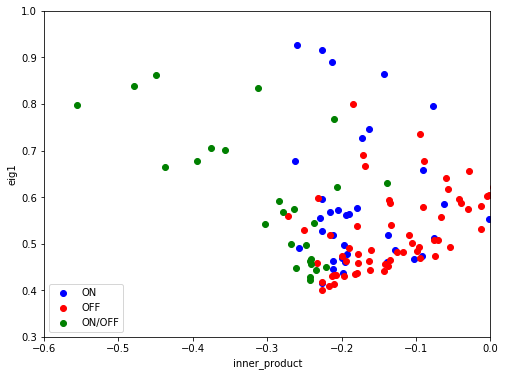

In [79]:
# plot inner_product vs. eig1

plt.figure(figsize=(8,6))
pysta.plot_scatter_by_group(cluster_combined, ["inner_product", "eig1"],
                            "cell_type_combined", ["ON", "OFF", "ON/OFF"], ["b","r","g"], alpha=1)                            
#                             "cell_type_combined", ["ON", "OFF", "ON/OFF","unknown"], ["b","r","g","k"])

plt.xlim(-0.6, 0)
plt.ylim(0.3, 1)

-0.6663352318152264

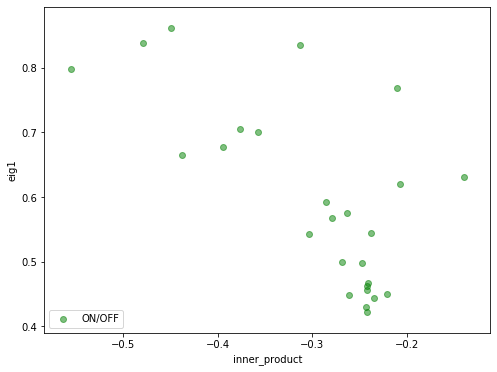

In [80]:
plt.figure(figsize=(8,6))
pysta.plot_scatter_by_group(cluster_combined, ["inner_product", "eig1"], 
                            "cell_type_combined", ["ON/OFF"], ['g'])

idx = cluster_combined["cell_type_combined"] == "ON/OFF"
np.corrcoef(cluster_combined.loc[idx,"inner_product"],cluster_combined.loc[idx,"eig1"])[0,1]

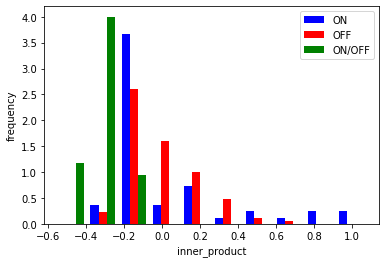

In [86]:
pysta.plot_hist_by_group(cluster_combined, "inner_product", 
                         "cell_type_combined", ["ON", "OFF", "ON/OFF"], ["b",'r','g'],
                         density=True)

In [ ]:
checked upto here

In [ ]:
# plt.figure()
plt.figure(figsize=(15,12))
plt.subplot(221)
pysta.plot_hist_by_group(cluster_combined, "num_spikes", "on_and_off", [True, False], color=["g", 'k'], bins=bins_for_num_spikes)
# plt.figure()
plt.subplot(222)
pysta.plot_hist_by_group(cluster_combined, "PSNR", "on_and_off", [True, False], color=["g", 'k'])
# plt.figure()
plt.subplot(223)
pysta.plot_hist_by_group(cluster_combined, "PSNR1", "on_and_off", [True, False], color=["g", 'k'])
# plt.figure()
plt.subplot(224)
pysta.plot_hist_by_group(cluster_combined, "PSNR2", "on_and_off", [True, False], color=["g", 'k'])

In [ ]:
plt.figure(figsize=(15,12))
plt.subplot(221)
pysta.plot_hist_by_group(cluster_combined, "num_spikes", "cell_type_clustered",["ON", "OFF", "ON/OFF", "unknown"], color=["b","r","g", 'k'], bins=bins_for_num_spikes)

plt.subplot(222)
pysta.plot_hist_by_group(cluster_combined, "PSNR", "cell_type_clustered", ["ON", "OFF", "ON/OFF", "unknown"], color=["b","r","g", 'k'])

plt.subplot(223)
pysta.plot_hist_by_group(cluster_combined, "eig1", "cell_type_clustered", ["ON", "OFF", "ON/OFF", "unknown"], color=["b","r","g", 'k'])

plt.subplot(224)
pysta.plot_hist_by_group(cluster_combined, "inner_product", "cell_type_clustered", ["ON", "OFF", "ON/OFF", "unknown"], color=["b","r","g", 'k'])

plt.savefig("figure/cluster_result_dim{}_spd{}.png".format(cluster_dim,spike_per_dim))
plt.savefig("figure/cluster_result_dim{}_spd{}.pdf".format(cluster_dim,spike_per_dim))
# cluster_combined.hist("PSNR", by="cell_type_clustered", sharex=True)
# cluster_combined.hist("PSNR1", by="cell_type_clustered", sharex=True)
# cluster_combined.hist("PSNR2", by="cell_type_clustered", sharex=True)


In [ ]:
# original cell type vs. clustered
# col = "PSNR"
col = "num_spikes"
plt.figure()
bins_for_num_spikes=np.linspace(0,15000,15)
pysta.plot_hist_by_cell_type(cluster_combined, col, bins=bins_for_num_spikes)
plt.figure()
pysta.plot_hist_by_group(cluster_combined, col, "cell_type_clustered", ["ON","OFF","ON/OFF","unknown"], color=["r", "b", "g", "k"],bins=bins_for_num_spikes)

In [ ]:
# original cell type vs. clustered
plt.figure()
pysta.plot_hist_by_group(cluster_combined, "eig1", "cell_type", ["ON","OFF","unknown"], color=["r", "b", "k"])
plt.figure()
pysta.plot_hist_by_group(cluster_combined, "eig1", "cell_type_clustered", ["ON","OFF","ON/OFF","unknown"], color=["r", "b", "g", "k"])

In [ ]:
# original cell type vs. clustered
plt.figure()
pysta.plot_hist_by_group(cluster_combined, "inner_product", "cell_type", ["ON","OFF","unknown"], color=["r", "b", "k"])
plt.figure()
pysta.plot_hist_by_group(cluster_combined, "inner_product", "cell_type_clustered", ["ON","OFF","ON/OFF","unknown"], color=["r", "b", "g", "k"])

In [ ]:
plot_examples(cluster_checked, cluster_dim, temporal_profile=True, spatial_profile=[1, 2], filename="combined_cluster_dim{}_spd{}_checked".format(cluster_dim,spike_per_dim))

In [ ]:
# plt.hist(PSNR1_selected)
# plt.show()
# plt.hist(PSNR2_selected)
# plt.show()
# plt.scatter(PSNR1_selected,PSNR2_selected)
# plt.plot([5,25],[5,25], 'k--')
# plt.xlabel('PSNR1')
# plt.ylabel('PSNR2')
# plt.show()
# plt.scatter(PSNR_selected,PSNR1_selected)
# plt.scatter(PSNR_selected,PSNR2_selected)
# plt.plot([5,25],[5,25], 'k--')
# plt.xlabel('PSNR')
# plt.legend(['','PSNR1', 'PSNR2'])
# plt.show()

In [ ]:

plt.hist(cluster_checked["cell_type"])

print(len(cluster_checked))
cluster_checked["cell_type"].value_counts()

In [ ]:
# # sort by inner product and plot

# cluster_sorted_by_eig1 = cluster_with_enough_samples.sort_values('eig1').head(30)#.sort_values("dataset")

# plot_examples(cluster_sorted_by_eig1, "cluster_eig", dim=dim)




In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)
pysta.plot_scatter_by_cell_type(cluster_checked,["PSNR","PSNR1"])
plt.plot([7.5,25], [7.5,25], 'k--')
plt.subplot(122)
pysta.plot_scatter_by_cell_type(cluster_checked,["PSNR","PSNR2"])
plt.plot([7.5,25], [7.5,25], 'k--')

In [ ]:
plot_scatter(cluster_checked)

## compare results with d=2 and d=3

In [ ]:
on_and_off_dim2 = pd.read_csv("on_and_off_dim2.csv")
on_and_off_dim3 = pd.read_csv("on_and_off_dim3.csv")



channel_on_and_off_dim2 = set(on_and_off_dim2["channel_name"])
channel_on_and_off_dim3 = set(on_and_off_dim3["channel_name"])
channel_on_and_off_union = channel_on_and_off_dim2.union(channel_on_and_off_dim3)
channel_on_and_off_intersection = channel_on_and_off_dim2.intersection(channel_on_and_off_dim3)

print(len(channel_on_and_off_dim2))
print(len(channel_on_and_off_dim3))
print(len(channel_on_and_off_union))
print(len(channel_on_and_off_intersection))

print("union:", channel_on_and_off_union)
print("intersect:", channel_on_and_off_intersection)
print("dim=2 only:", channel_on_and_off_dim2 - channel_on_and_off_dim3)
print("dim=3 only:", channel_on_and_off_dim3 - channel_on_and_off_dim2)

In [ ]:
# compare results
d2 = np.load("data/clustered_dim2.npz", allow_pickle=True)
d2_channel_names = [info["channel_name"] for info in d2["info"]]

d3 = np.load("data/clustered_dim3.npz", allow_pickle=True)
d3_channel_names = [info["channel_name"] for info in d3["info"]]    

def find_channel_index(channel_names, channel_name):
    for i, ch in enumerate(channel_names):
        if ch == channel_name:
            return i
    return None # not found

for channel_name in channel_on_and_off_union:
    print(channel_name)
        
    idx2 = find_channel_index(d2_channel_names, channel_name)
    idx3 = find_channel_index(d3_channel_names, channel_name)    
#     print(idx2, idx3)

    is_on_and_off_dim2 = channel_name in channel_on_and_off_dim2    
    is_on_and_off_dim3 = channel_name in channel_on_and_off_dim3
    print(is_on_and_off_dim2, is_on_and_off_dim3)
    
    sta = d2['X_train'][idx2]
    group_center1 = d2['X_test'][idx2*2]
    group_center2 = d2['X_test'][idx2*2+1]    

    tap = 8
    dt = 100
    grid_T = np.linspace(-tap + 1, 0, tap) * dt
    stcl.plot_centers(sta, [group_center1, group_center2], grid_T)
    
    sta = d3['X_train'][idx3]
    group_center1 = d3['X_test'][idx3*2]
    group_center2 = d3['X_test'][idx3*2+1]    
    stcl.plot_centers(sta, [group_center1, group_center2], grid_T)
    

In [ ]:
 d2['X_test'].shape

In [ ]:
d2["X_train"].shape

In [ ]:
d3_channel_names

In [ ]:
for k in d2.keys():
    print(k)